# Méthodes

## Méthodes pour le nettoyage des données

In [1]:
# pour filtrer les colonnes en fonction de leur taux de valeurs manquantes
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% inclu à", pct_max, "% exclu.")
    # extraction des colonnes remplissant la condition de filtrage
    tot_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    tot_list_col = pd.DataFrame(tot_list_col, columns = ["%"])
    remain_list_col = tot_list_col.loc[(tot_list_col["%"] >= pct_min) & (tot_list_col["%"] < pct_max), :]
    nb_col_remained = len(remain_list_col)
    nb_col_removed = len(tot_list_col) - nb_col_remained
    print("Après filtrage, il reste", nb_col_remained, "colonnes dans le DataFrame.")
    print("Il y a eu suppression de", nb_col_removed, "colonnes, soit", round(nb_col_removed/len(tot_list_col)*100, 2), "% des colonnes.")
    
    # test sur le nb de colonnes restantes
    if len(remain_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[remain_list_col.index]
    return result

In [2]:
# pour supprimer les colonnes vides en passant par la méthode de filtre en fonction du taux de valeurs manquantes
def remove_empty_columns(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.")
    result = filter_col_by_mising_data_pct(df)
    return result    

In [3]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

## Méthodes pour le PCA

In [4]:
# pour utiliser la méthode du PCA et afficher l'éboulis des inerties entre les variables
def compute_pca(df, n_components=2):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    # split des données
    X = df.values
    names = df.index
    features = df.columns
    
    print("L'échantillon présente", df.shape[0], "lignes et", df.shape[1], "colonnes")
    # vérif n_components
    if n_components > min(len(df), len(features)):
        print("Le nombre de composantes est trop élevée. On le recale à la valeur maximale.")
        print("La nouvelle valeur sera le minimum entre le nombre de ligne dans l'échantillon et le nombre de features, càd", min(len(df), len(features)))
        n_components = min(len(df), len(features))
    
    scaler = StandardScaler() # instance de scaler
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components) # instance de PCA
    pca.fit(X_scaled) # entrainement sur les données scalées
    
    # print("Valeurs propres (mieux si > 1):", pca.explained_variance_)
    print("Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.")
    nb_opti_val_p = [x for x in pca.explained_variance_ if x >= 0.9]
    print("Ici, la méthode des valeurs propres nous demande de garder", len(nb_opti_val_p), "composantes.")
    # print("Variance ratio", pca.explained_variance_ratio_)
    
    # tracé de l'éboulis des valeurs propres
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    print("La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.")
    nb_opti_95_inertie = [x for x in scree_cum if x <= 95]
    print("Ici, la méthode des 95% d'inertie nous demande de garder", len(nb_opti_95_inertie), "composantes.")
    
    x_list = range(1, n_components+1)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
    return pca

In [5]:
def show_components_heatmap(df, pca):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = df.columns # features
    n_components = len(pcs)
    x_list = range(1, n_components+1)
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)
    # représentation visuelle
    gif, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
    return pcs


In [6]:
def compute_components(pcs, threshold=0.6):
    result = []
    for index, row in pcs.iterrows():
        for col in pcs.columns:
            if abs(row[col]) >= threshold:
                print(col, ":", row[col])
                result.append(col)
    
    result = list(set(result))
    print("Il y a", len(result), "variables ayant un impact conséquent sur les composantes.")
    print("Voici la liste :", result)
    return result

Méthode pour ANOVA

In [7]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## Méthode pour affichage personnalisé

In [8]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

***
# II) Présentation générale du jeu de données

## 1) Exploration du dataset

### a) Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.metrics import r2_score
# sns.set()

### b) Chargement du dataset

Il y avait un problème de données à cheval sur plusieurs lignes. Un script a permis de corriger le problème. Voici le fichier corrigé en entrée.

In [10]:
# Le séparateur dans le dataset est la tabulation
raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')

/tmp/ipykernel_3539/2650904854.py:2: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')


In [11]:
print("Le dataset brut présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")
raw_data.head()

Le dataset brut présente 320749 lignes et 162 colonnes


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
## 2) Traitement de réduction et de sélection des données

Le dataset présente énormément de colonnes et de lignes. Nous voulons le réduire pour faciliter son exploitation.  
Dès à présent, nous devons avoir une approche métier de ce dataset. Notre objectif est de qualifier la qualité des produits. Certes, nous ne savons pas encore quel modèle nous utiliserons. Cependant, en regardons de plus près le dataset, nous pouvons remarquer 2 target possibles `nutrition-score-fr_100g` et `nutrition_grade_fr`. Il faut donc absolument que ces variables soient remplies à la base. Nous pouvons donc supprimer toutes les lignes de produits n'ayant pas de renseigné soit l'une, soit l'autre.

### a) Suppression colonnes vides

Regardons d'abord s'il y a des colonnes très peu renseignées.

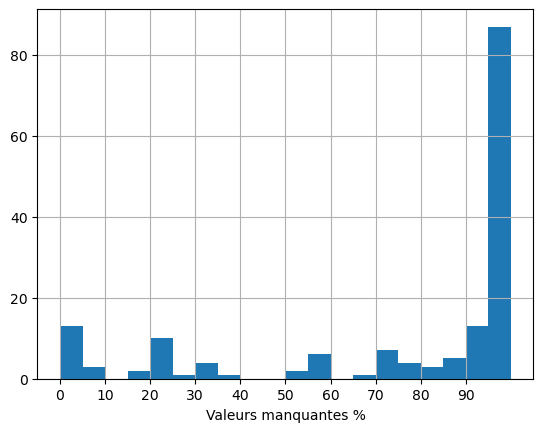

In [12]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df["%"].hist(bins=20)
plt.xlabel("Valeurs manquantes %")
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(0, 100, 10))
plt.show()

In [13]:
miss_val_inf_5 = missing_val_df.loc[missing_val_df["%"]<=5, :]
print("Les colonnes ayant moins de 5 % de valeurs manquantes sont au nombre de", len(miss_val_inf_5), "soit,", round(len(miss_val_inf_5)/raw_data.shape[1]*100, 1), "% des colonnes.")
miss_val_sup_95 = missing_val_df.loc[missing_val_df["%"]>=95, :]
print("Les colonnes ayant plus de 95 % de valeurs manquantes sont au nombre de", len(miss_val_sup_95), "soit,", round(len(miss_val_sup_95)/raw_data.shape[1]*100, 1), "% des colonnes.")

Les colonnes ayant moins de 5 % de valeurs manquantes sont au nombre de 13 soit, 8.0 % des colonnes.
Les colonnes ayant plus de 95 % de valeurs manquantes sont au nombre de 87 soit, 53.7 % des colonnes.


In [14]:
# On supprime les colonnes vides
data_wo_col_vide = remove_empty_columns(raw_data)

Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.
Le DataFrame à filtrer présente 320749 lignes et 162 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 100 % exclu.
Après filtrage, il reste 141 colonnes dans le DataFrame.
Il y a eu suppression de 21 colonnes, soit 12.96 % des colonnes.


In [16]:
print("Une fois les colonnes vides supprimées du dataset brut, il reste", data_wo_col_vide.shape[0], "lignes et", data_wo_col_vide.shape[1], "colonnes")
raw_data.head()

Une fois les colonnes vides supprimées du dataset brut, il reste 320749 lignes et 141 colonnes


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En étudiant les colonnes, j'ai choisi une limite de taux de valeurs manquantes à 99.3%. En effet, dans les colonnes au-delà de ce taux, je n'ai pas remarqué d'intérêt pour notre étude.

In [15]:
pct_miss_val_keep = 99.3
miss_val_90 = missing_val_df.loc[missing_val_df["%"]>pct_miss_val_keep, :]
print("Les colonnes ayant plus de", pct_miss_val_keep, "% de valeurs manquantes sont au nombre de", len(miss_val_90), "soit,", round(len(miss_val_90)/raw_data.shape[1]*100, 1), "% des colonnes.")

Les colonnes ayant plus de 99.3 % de valeurs manquantes sont au nombre de 70 soit, 43.2 % des colonnes.


In [16]:
# On supprime les colonnes ayant plus de 99% de valeurs manquantes
data_filt_90p = filter_col_by_mising_data_pct(data_w_target, pct_min=0, pct_max=pct_miss_val_keep)

Le DataFrame à filtrer présente 221233 lignes et 162 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 99.3 % exclu.
Après filtrage, il reste 92 colonnes dans le DataFrame.
Il y a eu suppression de 70 colonnes, soit 43.21 % des colonnes.


### b) Suppression lignes target vides

In [12]:
# le nutriscore sera notre target, donc on peut supprimer toutes les lignes n'ayant pas de nutriscore renseigné
data_w_target = raw_data.loc[(raw_data["nutrition-score-fr_100g"].notnull()) | (raw_data["nutrition_grade_fr"].notnull()), :]
print("Il y a", raw_data.shape[0] - data_w_target.shape[0], "lignes sans Nutri-Score ou Nutri-Grade de renseigné, soit", round((1-data_w_target.shape[0]/raw_data.shape[0])*100, 2), "% des données.")
data_w_target.reset_index(drop=True)

Il y a 99516 lignes sans Nutri-Score ou Nutri-Grade de renseigné, soit 31.03 % des données.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
1,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
3,16124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN
4,16872,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055650,2017-03-09T10:34:10Z,1489055651,2017-03-09T10:34:11Z,Zen Party Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221228,9787461062105,http://world-fr.openfoodfacts.org/produit/9787...,usda-ndb-import,1489092300,2017-03-09T20:45:00Z,1489092300,2017-03-09T20:45:00Z,Natural Cassava,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN
221229,9847548283004,http://world-fr.openfoodfacts.org/produit/9847...,drmalabar,1437817626,2015-07-25T09:47:06Z,1442237848,2015-09-14T13:37:28Z,Tartines craquantes bio au sarrasin,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4.0,NaN,NaN
221230,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,1491079938,2017-04-01T20:52:18Z,1491079939,2017-04-01T20:52:19Z,Amandes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
221231,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,thé bio équitable,50 g,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN


### c) Séparation des colonnes par type de données

Séparons maintenant les colonnes par type de données : 
 - variables catégorielles : sélectionnons les plus pertinentes
 - variables numériques : pourrons être réduites par 2 études (corrélation et PCA)

In [17]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_filt_90p)

Voici la répartition des colonnes par type de données :
numeric : 40 colonnes.
category : 52 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [18]:
print("Le dataset est réparti comme suit :")
print("Colonnes de type numérique :", len(data_num.columns), "soit,", round(len(data_num.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")
print("Colonnes de type catégoriel :", len(data_categ.columns), "soit,", round(len(data_categ.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")

Le dataset est réparti comme suit :
Colonnes de type numérique : 40 soit, 24.7 % des colonnes.
Colonnes de type catégoriel : 52 soit, 32.1 % des colonnes.


### d) Sélection des variables catégorielles pertinentes

In [19]:
# regardons la liste des colonnes catégorielles
print(data_categ.columns)

Index(['ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_tags', 'origins_tags', 'origins',
       'first_packaging_code_geo', 'cities_tags', 'traces_fr', 'traces_tags',
       'traces', 'emb_codes_tags', 'emb_codes', 'allergens',
       'manufacturing_places_tags', 'manufacturing_places', 'labels',
       'labels_fr', 'labels_tags', 'stores', 'generic_name', 'purchase_places',
       'image_url', 'image_small_url', 'packaging_tags', 'packaging',
       'categories', 'categories_tags', 'main_category', 'main_category_fr',
       'categories_fr', 'pnns_groups_1', 'pnns_groups_2', 'quantity',
       'additives_fr', 'additives_tags', 'serving_size', 'additives',
       'ingredients_text', 'brands_tags', 'brands', 'product_name',
       'countries', 'countries_tags', 'countries_fr', 'created_datetime',
       'url', 'nutrition_grade_fr', 'states', 'states_tags', 'states_fr',
       'last_modified_datetime', 'creator', 'code'],
      dtype='object')


Toujours dans notre approche métier, nous devons qualifier la qualité des produits. Il n'y a qu'une variable catégorielle le permettant, c'est `nutrition_grade_fr`. Elle nous servira de target pour certains algorithmes.  
Nous allons également sélectionner les colonnes `code` et `product_name` car elle nous permettront d'identifier les produits.

In [20]:
# liste des colonnes catégorielles à supprimer
col_categ_to_select = ['nutrition_grade_fr', 'code', 'product_name']
print("Sélection de", len(col_categ_to_select), "colonnes catégorielles utiles soit,", round(len(col_categ_to_select)/len(raw_data.columns)*100, 1), "% des colonnes.")
col_categ_to_drop = [x for x in data_categ.columns if x not in col_categ_to_select]
print("Suppression de", len(col_categ_to_drop), "colonnes catégorielles inutiles soit,", round(len(col_categ_to_drop)/len(raw_data.columns)*100, 1), "% des colonnes.")

Sélection de 3 colonnes catégorielles utiles soit, 1.9 % des colonnes.
Suppression de 49 colonnes catégorielles inutiles soit, 30.2 % des colonnes.


In [21]:
# suppression des colonnes categ
data_drop_categ = data_filt_90p.drop(col_categ_to_drop, axis=1)

### e) Sélection des variables numériques

In [22]:
# regardons la liste des colonnes numériques
print(data_num.columns)

Index(['alcohol_100g', 'pantothenic-acid_100g', 'copper_100g', 'folates_100g',
       'fruits-vegetables-nuts_100g', 'zinc_100g', 'vitamin-b12_100g',
       'vitamin-b9_100g', 'magnesium_100g', 'phosphorus_100g',
       'vitamin-b6_100g', 'vitamin-d_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b1_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'potassium_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'iron_100g', 'calcium_100g', 'trans-fat_100g',
       'cholesterol_100g', 'fiber_100g', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'carbohydrates_100g',
       'fat_100g', 'sugars_100g', 'sodium_100g', 'proteins_100g', 'salt_100g',
       'energy_100g', 'saturated-fat_100g', 'last_modified_t', 'created_t',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')


En regardant la liste des variables numériques, on peut voir, tout de suite, celles qui ne nous serons pas utiles dans notre démarche métier. Il s'agit des colonnes `last_modified_t` et `created_t` qui renseignent sur la date de création et de modification de la fiche produit.

In [23]:
col_num_to_drop = ['last_modified_t', 'created_t']

***
Regardons maintenant les corrélations fortes entre variables. Ainsi nous pourrons réduire le nombre de colonnes.

In [24]:
# extraire les variables étant très corrélées > 0.9
list_col_num = data_num.columns
corr = data_filt_90p[list_col_num].corr().values
nb_col = len(data_num.columns)
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.9:
            print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])

zinc_100g   vitamin-b9_100g   0.983581901120278
sodium_100g   salt_100g   0.9999999999807522
nutrition-score-fr_100g   nutrition-score-uk_100g   0.9862214436289298


Il y a plusieurs colonnes corrélées deux à deux. Nous pouvons en supprimer comme suit :  
|Colonne à garder|Colonne à supprimer|
|--|--|
|vitamin-b9_100g|zinc_100g|
|nutrition-score-fr_100g|nutrition-score-uk_100g|
|salt_100g|sodium_100g|

In [25]:
# concatenation des colonnes numériques à supprimer
col_num_to_drop = col_num_to_drop + ['zinc_100g', 'nutrition-score-uk_100g', 'sodium_100g']
print("Suppression de", len(col_num_to_drop), "colonnes numériques inutiles soit,", round(len(col_num_to_drop)/len(raw_data.columns)*100, 1), "% des colonnes.")
# suppression des colonnes numériques
data_drop_num = data_drop_categ.drop(col_num_to_drop, axis=1)

Suppression de 5 colonnes numériques inutiles soit, 3.1 % des colonnes.


In [26]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_drop_num)
print("Sélection de", len(data_num.columns), "colonnes numériques utiles soit,", round(len(data_num.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")

Voici la répartition des colonnes par type de données :
numeric : 35 colonnes.
category : 3 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.
Sélection de 35 colonnes numériques utiles soit, 21.6 % des colonnes.


In [27]:
print("Le dataset après le 1er nettoyage présente", data_drop_num.shape[0], "lignes et", data_drop_num.shape[1], "colonnes")
data_drop_num.head()

Le dataset après le 1er nettoyage présente 221233 lignes et 38 colonnes


,alcohol_100g,pantothenic-acid_100g,copper_100g,folates_100g,fruits-vegetables-nuts_100g,vitamin-b12_100g,vitamin-b9_100g,magnesium_100g,phosphorus_100g,vitamin-b6_100g,...,fat_100g,product_name,sugars_100g,proteins_100g,salt_100g,energy_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,code
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.57,Banana Chips Sweetened (Whole),14.29,3.57,0.00000,2243.0,28.57,d,14.0,4530
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.86,Peanuts,17.86,17.86,0.63500,1941.0,0.00,b,0.0,4559
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.14,Organic Salted Nut Mix,3.57,17.86,1.22428,2540.0,5.36,d,12.0,16087
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.75,Organic Muesli,15.62,14.06,0.13970,1833.0,4.69,c,7.0,16124
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.67,Zen Party Mix,3.33,16.67,1.60782,2230.0,5.00,d,12.0,16872


***
## 3) Traitement de nettoyage des données

### a) Traitements des valeurs manquantes

In [28]:
# voici la répartition des données manquantes pour les données numériques
miss_num = round(data_drop_num[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
miss_num_df.head(40)

,%
alcohol_100g,99.2822
pantothenic-acid_100g,99.2103
copper_100g,99.0878
folates_100g,98.7430
fruits-vegetables-nuts_100g,98.7222
vitamin-b12_100g,98.1526
vitamin-b9_100g,97.7350
magnesium_100g,97.5713
phosphorus_100g,97.5614
vitamin-b6_100g,97.5284


Pour les valeurs manquantes, nous faisons l'approximation de mettre toutes les valeurs numériques à 0. En effet, si elles ne sont pas renseignées, c'est souvent parce qu'elles n'existent tout simplement pas sur l'étiquette. Une différente approche renseignerait des valeurs arbitraires. Par ailleurs, on sait que la valeur énergétique `energy_100g` provient d'une formule dépendant des variables suivantes : `proteins_100g`, `carbohydrates_100g` et `fat_100g`.  
En résumé, nous pouvons renseigner la valeur 0 pour toutes les valeurs manquantes exceptées pour `energy_100g`. Pour cette dernière, nous devons avoir une approche différente.

In [29]:
# regardons les données sur les lignes n'ayant pas de valeur énergétique
data_wo_energy = data_drop_num.loc[data_drop_num["energy_100g"].isnull(), :]
miss_num = round(data_wo_energy.isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
print(miss_num_df)
print("Il y a", len(data_wo_energy), "lignes n'ayant pas de valeur pour énergétique, soit", round(len(data_wo_energy)/len(raw_data)*100, 3), "% des colonnes.")

                                                %
iron_100g                                100.0000
sugars_100g                              100.0000
fat_100g                                 100.0000
carbohydrates_100g                       100.0000
salt_100g                                100.0000
energy_100g                              100.0000
saturated-fat_100g                       100.0000
fiber_100g                               100.0000
cholesterol_100g                         100.0000
trans-fat_100g                           100.0000
calcium_100g                             100.0000
pantothenic-acid_100g                    100.0000
vitamin-c_100g                           100.0000
vitamin-a_100g                           100.0000
potassium_100g                           100.0000
polyunsaturated-fat_100g                 100.0000
monounsaturated-fat_100g                 100.0000
vitamin-b1_100g                          100.0000
vitamin-pp_100g                          100.0000


On remarque que les lignes de produits n'ayant pas de valeur énergétique ont également aucune des variables de nutrition de renseignées. On peut donc tout simplement les surpprimer du dataset.

In [30]:
# suppression des lignes n'ayant pas de valeur énergétique renseignée
data_drop_nrj = data_drop_num.loc[data_drop_num["energy_100g"].notnull(), :]
data_drop_nrj.reset_index(drop=True)

,alcohol_100g,pantothenic-acid_100g,copper_100g,folates_100g,fruits-vegetables-nuts_100g,vitamin-b12_100g,vitamin-b9_100g,magnesium_100g,phosphorus_100g,vitamin-b6_100g,...,fat_100g,product_name,sugars_100g,proteins_100g,salt_100g,energy_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.57,Banana Chips Sweetened (Whole),14.29,3.57,0.00000,2243.0,28.57,d,14.0,4530
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.86,Peanuts,17.86,17.86,0.63500,1941.0,0.00,b,0.0,4559
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.14,Organic Salted Nut Mix,3.57,17.86,1.22428,2540.0,5.36,d,12.0,16087
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.75,Organic Muesli,15.62,14.06,0.13970,1833.0,4.69,c,7.0,16124
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.67,Zen Party Mix,3.33,16.67,1.60782,2230.0,5.00,d,12.0,16872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,Natural Cassava,2.35,1.18,0.03048,1477.0,0.00,a,-1.0,9787461062105
221038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186,NaN,NaN,...,2.80,Tartines craquantes bio au sarrasin,2.60,13.00,0.68000,1643.0,0.60,a,-4.0,9847548283004
221039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Amandes,3.89,21.22,0.10000,2406.0,3.73,b,0.0,9900000000233
221040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,Thé vert Earl grey,0.50,0.50,0.02540,21.0,0.20,c,2.0,99111250


In [31]:
# regardons ensuite les variables étant obligatoirement affichées sur l'étiquette
col_mandatory = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
for col in col_mandatory[1:]:
    data_wo_mandatory = data_drop_nrj.loc[data_drop_nrj[col].isnull(), :]
    if len(data_wo_mandatory) > 0:
        print("Pour la colonne", col, ", il manque", len(data_wo_mandatory) , "lignes, soit", round(len(data_wo_mandatory)/len(raw_data)*100, 2), "% des colonnes.")

Pour la colonne fat_100g , il manque 17286 lignes, soit 5.39 % des colonnes.
Pour la colonne carbohydrates_100g , il manque 17312 lignes, soit 5.4 % des colonnes.


On observe que seules les colonnes `fat_100g` et `carbohydrates_100g` présentent des données manquantes. Nous savons que ces variables sont composées comme suit :  
 - `fat_100g` = `saturated-fat_100g` + `trans-fat_100g` + `polyunsaturated-fat_100g` + `monounsaturated-fat_100g` au minimum
 - `carbohydrates_100g` = `sugars_100g` au minimum; + `glucose_100g` + `fructose_100g` mais sont à plus de 99.99% vides

Nous allons donc faire l'approximation d'utiliser ces sommes pour remplir la valeurs manquantes.

In [32]:
# remplissage de fat_100g
mask_fat = data_drop_nrj["fat_100g"].isnull()
data_drop_nrj.loc[mask_fat, "fat_100g"] = data_drop_nrj.loc[mask_fat, ["saturated-fat_100g", "trans-fat_100g", "polyunsaturated-fat_100g", "monounsaturated-fat_100g"]].sum(axis=1)

In [33]:
# remplissage de carbohydrates_100g
mask_carbo = data_drop_nrj["carbohydrates_100g"].isnull()
data_drop_nrj.loc[mask_carbo, "carbohydrates_100g"] = data_drop_nrj.loc[mask_carbo, "sugars_100g"]

Pour toutes les autres variables, nous pouvons renseigner la valeur 0

In [34]:
nb_miss_num = data_drop_nrj[data_num.columns].isnull().sum().sum()
nb_tot_data = data_drop_nrj.shape[0] * len(data_num.columns)
print("Pour les autres variables numériques, il manque", nb_miss_num , "entrées, soit", round(nb_miss_num/nb_tot_data*100, 2), "% des données numériques.")

Pour les autres variables numériques, il manque 4242794 entrées, soit 54.84 % des données numériques.


In [35]:
# toutes les valeurs numériques sont remplies à 0
for col in data_num.columns:
    data_drop_nrj[col].fillna(0, inplace=True)

/tmp/ipykernel_6697/2136430834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_nrj[col].fillna(0, inplace=True)


Concernant les variables catégoricielles, pour le `product_name`, on renseigne ses valeurs manquantes par celle de la colonne `code`.

In [36]:
mask_code_to_prod = data_drop_nrj["product_name"].isnull()
nb_product_miss = data_drop_nrj.loc[mask_code_to_prod, "product_name"]
print("Pour la colonne Nom du produit, il manque", len(nb_product_miss) , "lignes, soit", round(len(nb_product_miss)/len(raw_data)*100, 2), "% des données.")
data_drop_nrj.loc[mask_code_to_prod, "product_name"] = data_drop_nrj["code"]

Pour la colonne Nom du produit, il manque 2742 lignes, soit 0.85 % des données.


### b) Traitements des outliers

In [37]:
# afficher les possibles outliers
data_drop_nrj[data_num.columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alcohol_100g,221042.0,2.708671e-03,0.276403,0.000000,0.00,0.0000,0.000000,9.790000e+01
pantothenic-acid_100g,221042.0,5.559606e-04,0.150202,0.000000,0.00,0.0000,0.000000,6.000000e+01
copper_100g,221042.0,5.147898e-05,0.038013,-6.896552,0.00,0.0000,0.000000,1.648352e+01
folates_100g,221042.0,1.996646e-03,0.467458,0.000000,0.00,0.0000,0.000000,1.666667e+02
fruits-vegetables-nuts_100g,221042.0,3.836188e-01,4.949562,0.000000,0.00,0.0000,0.000000,1.000000e+02
vitamin-b12_100g,221042.0,2.445419e-07,0.000073,0.000000,0.00,0.0000,0.000000,3.390000e-02
vitamin-b9_100g,221042.0,1.624509e-04,0.051609,0.000000,0.00,0.0000,0.000000,2.307692e+01
magnesium_100g,221042.0,1.106576e-02,2.010828,0.000000,0.00,0.0000,0.000000,6.571430e+02
phosphorus_100g,221042.0,1.536108e-02,1.954548,0.000000,0.00,0.0000,0.000000,5.594590e+02
vitamin-b6_100g,221042.0,6.966067e-04,0.211438,0.000000,0.00,0.0000,0.000000,9.260000e+01


On observe tout de suite que des valeurs négatives ne sont pas possibles pour les teneurs en différents composants. En revanche, nous savons que la Nutri-Score peut avoir des valeurs allant de -15 à 40. Excepté cette variable, nous allons caler toutes les valeurs négatives à 0.

In [38]:
# toutes les valeurs négatives, sauf le nutriscore sont calées à 0
nb_num_neg = 0
for col in [x for x in data_num.columns if x != "nutrition-score-fr_100g"]:
    temp_nb_num_neg = data_drop_nrj.loc[data_drop_nrj[col]<0, :]
    if len(temp_nb_num_neg) > 0:
        print("Colonnes", col)
        nb_num_neg += len(temp_nb_num_neg)
        data_drop_nrj.loc[data_drop_nrj[col]<0, col] = 0  
print("Toutes les valeurs négatives sont calées à 0, exceptée le Nutri-Score. Elles représentent", nb_num_neg, "valeurs, soit", round(nb_num_neg/len(raw_data)*100, 3), "% du dataset.")

Colonnes copper_100g
Colonnes vitamin-c_100g
Colonnes iron_100g
Colonnes trans-fat_100g
Colonnes sugars_100g
Colonnes proteins_100g
Toutes les valeurs négatives sont calées à 0, exceptée le Nutri-Score. Elles représentent 14 valeurs, soit 0.004 % du dataset.


Concernant les valeurs maximales, il y a plusieurs cas : 
 - le Nutri-Score `nutrition-score-fr_100g` est bien à 40
 - la valeur énergétique `energy_100g` ne peut dépasser les 3700 kJ, nous calerons donc toutes les valeurs supérieures à celle-ci
 - les teneurs en composant de base pour 100g ne peuvent dépasser les 100g, nous les calerons donc à 100
 - les teneurs en composant en vitamines et sels minéraux, qui sont exprimées en mg ou µg. Nous les laisserons donc ainsi. Voici la liste de ceux qui dépassent les 100 : 
    - `folates_100g`
    - `magnesium_100g`
    - `phosphorus_100g`
    - `vitamin-b1_100g`
    - `potassium_100g`
    - `vitamin-c_100g`
    - `calcium_100g`

In [39]:
# ajustement des valeurs supérieures à 0 le nécessitant
col_to_fix_100 = ["polyunsaturated-fat_100g", "monounsaturated-fat_100g", "trans-fat_100g", "fiber_100g", "carbohydrates_100g", "fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "alcohol_100g"]
print("Une étude métier nous permet de distinguer", len(col_to_fix_100), "colonnes devant être limitées à la valeur 100")
nb_num_sup_cent_ok = 0
for col in col_to_fix_100:
    temp_nb_num_sup_cent_ok = data_drop_nrj.loc[data_drop_nrj[col]>100, :]
    nb_num_sup_cent_ok += len(temp_nb_num_sup_cent_ok)
    data_drop_nrj.loc[data_drop_nrj[col]>100, col] = 100
print("Toutes les valeurs supérieures à 100 sont calées à 100. Elles représentent", nb_num_sup_cent_ok, "valeurs, soit", round(nb_num_sup_cent_ok/len(raw_data)*100, 2), "% du dataset.")

Une étude métier nous permet de distinguer 11 colonnes devant être limitées à la valeur 100
Toutes les valeurs supérieures à 100 sont calées à 100. Elles représentent 89 valeurs, soit 0.03 % du dataset.


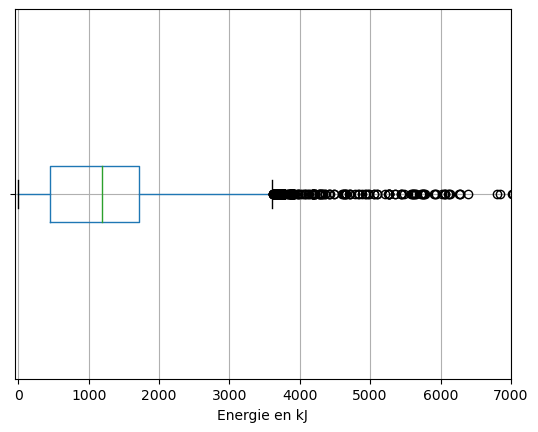

In [40]:
# exploration des outliers max en énergie
data_drop_nrj.boxplot(column="energy_100g", vert=False, showfliers=True)
plt.xlabel("Energie en kJ")
plt.yticks([1], [''])
plt.xlim((-50, 7000))
plt.show()

In [41]:
# ajustement de la valeur énergétique à son maximum 3700
energy_max = 3700
nb_energy_sup_max = len(data_drop_nrj.loc[data_drop_nrj["energy_100g"]>energy_max, :])
print("Nous modifions la valeur de l'énergie pour", nb_energy_sup_max, "lignes, soit", round(nb_energy_sup_max/len(raw_data)*100, 2), "% du dataset.")
data_drop_nrj.loc[data_drop_nrj["energy_100g"]>energy_max, "energy_100g"] = energy_max

Nous modifions la valeur de l'énergie pour 442 lignes, soit 0.14 % du dataset.


In [42]:
print("Le dataset après le traitement des valeurs manquantes et des outliers présente", data_drop_nrj.shape[0], "lignes et", data_drop_nrj.shape[1], "colonnes")
data_drop_nrj.head()

Le dataset après le traitement des valeurs manquantes et des outliers présente 221042 lignes et 38 colonnes


,alcohol_100g,pantothenic-acid_100g,copper_100g,folates_100g,fruits-vegetables-nuts_100g,vitamin-b12_100g,vitamin-b9_100g,magnesium_100g,phosphorus_100g,vitamin-b6_100g,...,fat_100g,product_name,sugars_100g,proteins_100g,salt_100g,energy_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,code
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.57,Banana Chips Sweetened (Whole),14.29,3.57,0.00000,2243.0,28.57,d,14.0,4530
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.86,Peanuts,17.86,17.86,0.63500,1941.0,0.00,b,0.0,4559
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57.14,Organic Salted Nut Mix,3.57,17.86,1.22428,2540.0,5.36,d,12.0,16087
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.75,Organic Muesli,15.62,14.06,0.13970,1833.0,4.69,c,7.0,16124
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.67,Zen Party Mix,3.33,16.67,1.60782,2230.0,5.00,d,12.0,16872


### d) Suppression lignes dupliquées

Maintenant que nous avons fait tous les traitements de réduction, de sélection et d'ajustement de données, il nous reste à supprimer les valeurs dupliquées. Pour notre modèle, ce qui nous intéresse est de supprimer les lignes dont les variables numériques sont identiques. En effet, des doublons existent avec les mêmes valeurs mais des noms de produit différents.

In [43]:
# identification et suppressions des lignes dupliquées
nb_lignes_dupli_num = data_drop_nrj[data_num.columns].duplicated().sum()
print("Il y a", nb_lignes_dupli_num, "lignes dupliquées dans ce dataset, soit", round(nb_lignes_dupli_num/len(data_drop_nrj)*100, 1), "% du dataset.")
data_dupli_drop = data_drop_nrj.drop_duplicates(subset=data_num.columns).reset_index(drop=True)
print("Après suppression des lignes dupliquées, le dataset présente", data_dupli_drop.shape[0], "lignes et", data_dupli_drop.shape[1], "colonnes.")
data_dupli_drop.head()

Il y a 40858 lignes dupliquées dans ce dataset, soit 18.5 % du dataset.
Après suppression des lignes dupliquées, le dataset présente 180184 lignes et 38 colonnes.


,alcohol_100g,pantothenic-acid_100g,copper_100g,folates_100g,fruits-vegetables-nuts_100g,vitamin-b12_100g,vitamin-b9_100g,magnesium_100g,phosphorus_100g,vitamin-b6_100g,...,fat_100g,product_name,sugars_100g,proteins_100g,salt_100g,energy_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.57,Banana Chips Sweetened (Whole),14.29,3.57,0.00000,2243.0,28.57,d,14.0,4530
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.86,Peanuts,17.86,17.86,0.63500,1941.0,0.00,b,0.0,4559
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57.14,Organic Salted Nut Mix,3.57,17.86,1.22428,2540.0,5.36,d,12.0,16087
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.75,Organic Muesli,15.62,14.06,0.13970,1833.0,4.69,c,7.0,16124
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36.67,Zen Party Mix,3.33,16.67,1.60782,2230.0,5.00,d,12.0,16872


***
# III) Compréhension du dataset

## 1) Shape du dataset d'étude

In [44]:
# Bilan sur le dataset d'étude
data = data_dupli_drop
print("Notre dataset d'étude présente", data.shape[0], "lignes et", data.shape[1], "colonnes")
print("Par rapport à notre dataset brut, on a gardé", round(data.shape[0]/raw_data.shape[0]*100, 2), "% de lignes et", round(data.shape[1]/raw_data.shape[1]*100, 2), "% de colonnes.")
print("Par rapport à notre dataset brut, on a supprimé", round((1-data.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")

Notre dataset d'étude présente 180184 lignes et 38 colonnes
Par rapport à notre dataset brut, on a gardé 56.18 % de lignes et 23.46 % de colonnes.
Par rapport à notre dataset brut, on a supprimé 43.82 % de lignes et 76.54 % de colonnes.


In [45]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data)

Voici la répartition des colonnes par type de données :
numeric : 35 colonnes.
category : 3 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


## 2) Analyse univariée

Regardons la répartition des différentes variables disponibles dans notre dataset. Il y a tout d'abord des variables notables telles que `nutrition-score-fr_100g`, `energy_100g` et `carbohydrates_100g`.

moyenne :  9.265289925853573
médiane :  10.0
mode :  0    0.0
Name: nutrition-score-fr_100g, dtype: float64
min :  -15.0
max :  40.0
quartiles :  [1.0, 16.0]
variance :  79.62423897941824
écart-type :  8.923241506281125
coefficient de variation :  0.9630828152912941
skewness :  0.1201424269238245
kurtosis :  -0.9841199313648099


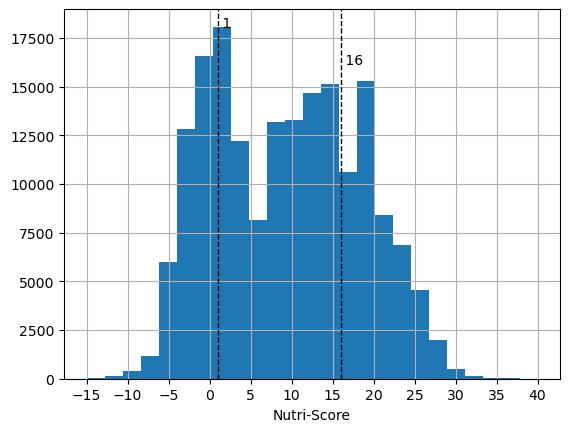

In [46]:
# Etude du Nutri-Score
# mesures de tendances centrales
print("moyenne : ", data["nutrition-score-fr_100g"].mean())
print("médiane : ", data["nutrition-score-fr_100g"].median())
print("mode : ", data["nutrition-score-fr_100g"].mode())
print("min : ", data["nutrition-score-fr_100g"].min())
print("max : ", data["nutrition-score-fr_100g"].max())
quartiles = [np.percentile(data["nutrition-score-fr_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["nutrition-score-fr_100g"].var(ddof=0))
print("écart-type : ", data["nutrition-score-fr_100g"].std(ddof=0))
print("coefficient de variation : ", data["nutrition-score-fr_100g"].std(ddof=0)/data["nutrition-score-fr_100g"].mean())
# mesures de forme
print("skewness : ", data["nutrition-score-fr_100g"].skew())
print("kurtosis : ", data["nutrition-score-fr_100g"].kurtosis())
data["nutrition-score-fr_100g"].hist(bins=25)
plt.xlabel("Nutri-Score")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(-15, 41, 5))
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
plt.show()

In [47]:
# Nutri-Score > 25
nb_ns_sup = data.loc[data["nutrition-score-fr_100g"]>=25,:]
print("Les produits ayant un Nutri-Score de plus de 25 représentent", round(len(nb_ns_sup)/len(data)*100, 1), "% du total.")
# Nutri-Score < -5
nb_ns_inf = data.loc[data["nutrition-score-fr_100g"]<=-5,:]
print("Les produits ayant un Nutri-Score de moins de -5 représentent", round(len(nb_ns_inf)/len(data)*100, 1), "% du total.")

Les produits ayant un Nutri-Score de plus de 25 représentent 4.0 % du total.
Les produits ayant un Nutri-Score de moins de -5 représentent 4.3 % du total.


moyenne :  1171.690766316654
médiane :  1151.0
mode :  0    2092.0
Name: energy_100g, dtype: float64
min :  0.0
max :  3700.0
quartiles :  [473.0, 1730.0]
variance :  562069.7153020618
écart-type :  749.7130886559617
coefficient de variation :  0.6398557624660403
skewness :  0.30882269059192213
kurtosis :  -0.6803970748910553


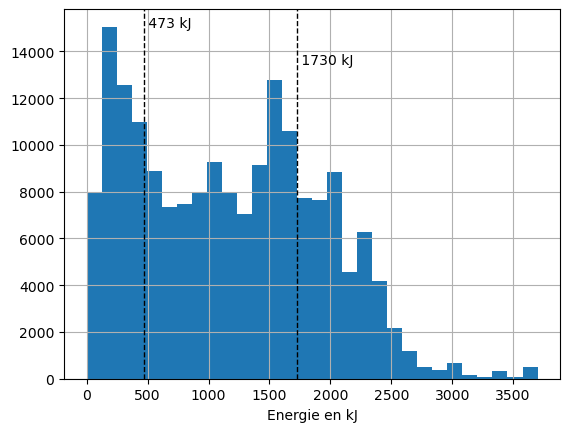

In [48]:
# Etude de l'énergie
# mesures de tendances centrales
print("moyenne : ", data["energy_100g"].mean())
print("médiane : ", data["energy_100g"].median())
print("mode : ", data["energy_100g"].mode())
print("min : ", data["energy_100g"].min())
print("max : ", data["energy_100g"].max())
quartiles = [np.percentile(data["energy_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["energy_100g"].var(ddof=0))
print("écart-type : ", data["energy_100g"].std(ddof=0))
print("coefficient de variation : ", data["energy_100g"].std(ddof=0)/data["energy_100g"].mean())
# mesures de forme
print("skewness : ", data["energy_100g"].skew())
print("kurtosis : ", data["energy_100g"].kurtosis())
data["energy_100g"].hist(bins=30)
plt.xlabel("Energie en kJ")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f} kJ'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} kJ'.format(quartiles[1]))
plt.show()

In [49]:
# énergie > 2500 kJ
nb_nrj_sup = data.loc[data["energy_100g"]>=2500,:]
print("Les produits ayant une valeur énergétique de plus de 2500 kJ représentent", round(len(nb_nrj_sup)/len(data)*100, 1), "% du total.")
# énergie < 250 kJ
nb_nrj_inf = data.loc[data["energy_100g"]<=250,:]
print("Les produits ayant une valeur énergétique de moins de 250 kJ représentent", round(len(nb_nrj_inf)/len(data)*100, 1), "% du total.")

Les produits ayant une valeur énergétique de plus de 2500 kJ représentent 3.1 % du total.
Les produits ayant une valeur énergétique de moins de 250 kJ représentent 13.0 % du total.


moyenne :  31.426242223948858
médiane :  22.12
mode :  0    0.0
Name: carbohydrates_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [6.67, 56.0]
variance :  748.9804834931633
écart-type :  27.36750780566552
coefficient de variation :  0.8708488788013504
skewness :  0.5291394302160471
kurtosis :  -1.070629313135793


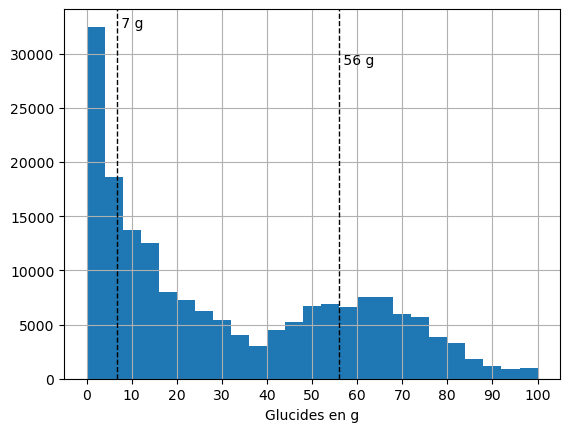

In [50]:
# Etude des glucides
# mesures de tendances centrales
print("moyenne : ", data["carbohydrates_100g"].mean())
print("médiane : ", data["carbohydrates_100g"].median())
print("mode : ", data["carbohydrates_100g"].mode())
print("min : ", data["carbohydrates_100g"].min())
print("max : ", data["carbohydrates_100g"].max())
quartiles = [np.percentile(data["carbohydrates_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["carbohydrates_100g"].var(ddof=0))
print("écart-type : ", data["carbohydrates_100g"].std(ddof=0))
print("coefficient de variation : ", data["carbohydrates_100g"].std(ddof=0)/data["carbohydrates_100g"].mean())
# mesures de forme
print("skewness : ", data["carbohydrates_100g"].skew())
print("kurtosis : ", data["carbohydrates_100g"].kurtosis())
data["carbohydrates_100g"].hist(bins=25)
plt.xlabel("Glucides en g")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(0, 101, 10))
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f} g'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} g'.format(quartiles[1]))
plt.show()

In [51]:
# glucides < 4 g
nb_carbo_inf = data.loc[data["carbohydrates_100g"]<=4,:]
print("Les produits ayant une teneur en glucides de moins de 4g représentent", round(len(nb_carbo_inf)/len(data)*100, 1), "% du total.")
# glucides > 80 g
nb_carbo_sup = data.loc[data["carbohydrates_100g"]>=80,:]
print("Les produits ayant une teneur en glucides de plus de 80g représentent", round(len(nb_carbo_sup)/len(data)*100, 1), "% du total.")
# glucides > 40g & < 80 g
nb_carbo_inter = data.loc[(data["carbohydrates_100g"]<=80) & (data["carbohydrates_100g"]>=40),:]
print("Les produits ayant une teneur en glucides comprise entre 40g et 80g représentent", round(len(nb_carbo_inter)/len(data)*100, 1), "% du total.")

Les produits ayant une teneur en glucides de moins de 4g représentent 18.4 % du total.
Les produits ayant une teneur en glucides de plus de 80g représentent 4.5 % du total.
Les produits ayant une teneur en glucides comprise entre 40g et 80g représentent 34.3 % du total.


Concernant toutes les autres variables numériques, les tendances sont similaires. Ils se répartissent principalement autour de la valeur 0. Ceci est dû à la quantité de valeurs manquantes.

moyenne :  12.603199293888467
médiane :  6.92
mode :  0    0.0
Name: fat_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.98, 20.0]
variance :  229.4438879747543
écart-type :  15.147405321531284
coefficient de variation :  1.2018698560830146
skewness :  1.8468205667574022
kurtosis :  4.70085398136537


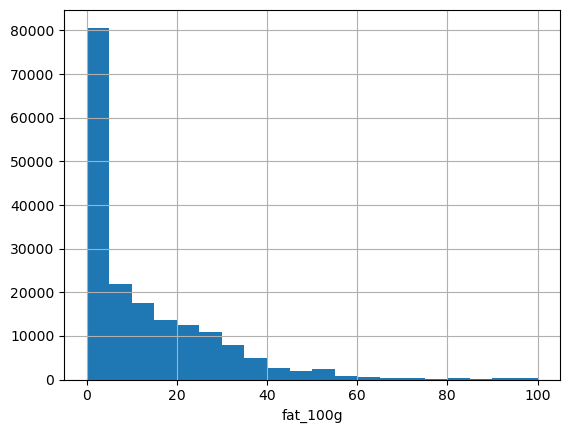

moyenne :  14.943769980020422
médiane :  5.56
mode :  0    0.0
Name: sugars_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [1.5, 23.33]
variance :  366.2432002672552
écart-type :  19.13748155498145
coefficient de variation :  1.2806327707511527
skewness :  1.5968835615656527
kurtosis :  2.0401373088599843


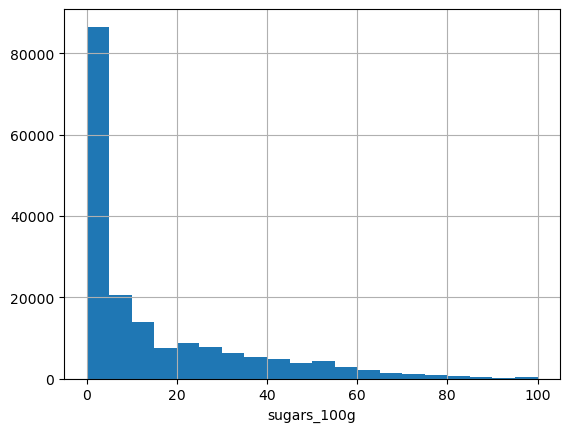

moyenne :  7.629492838431826
médiane :  5.71
mode :  0    0.0
Name: proteins_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [2.2, 10.53]
variance :  61.20720648561491
écart-type :  7.823503466198178
coefficient de variation :  1.0254290333413865
skewness :  2.185205777850782
kurtosis :  9.407610036110468


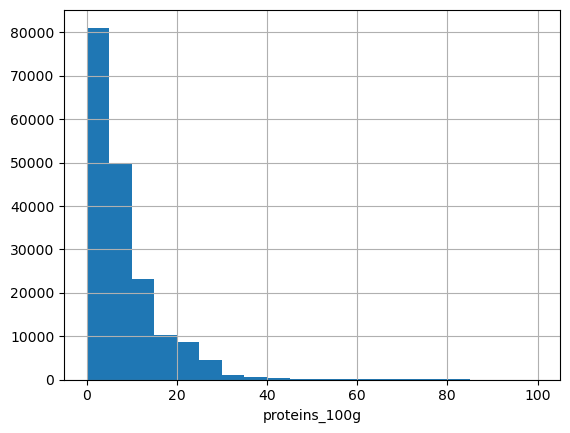

In [52]:
for col in ["fat_100g", "sugars_100g", "proteins_100g"] :
    print("moyenne : ", data[col].mean())
    print("médiane : ", data[col].median())
    print("mode : ", data[col].mode())
    print("min : ", data[col].min())
    print("max : ", data[col].max())
    quartiles = [np.nanpercentile(data[col], p) for p in [25, 75]]
    print("quartiles : ", quartiles)
    # mesures de dispersion
    print("variance : ", data[col].var(ddof=0))
    print("écart-type : ", data[col].std(ddof=0))
    print("coefficient de variation : ", data[col].std(ddof=0)/data[col].mean())
    # mesures de forme
    print("skewness : ", data[col].skew())
    print("kurtosis : ", data[col].kurtosis())
    data[col].hist(bins=20)
    # plt.ylim((0, 25000))
    plt.xlabel(col)
    plt.show()

moyenne :  0.003252397549171958
médiane :  0.0
mode :  0    0.0
Name: alcohol_100g, dtype: float64
min :  0.0
max :  97.9
quartiles :  [0.0, 0.0]
variance :  0.09342646903977996
écart-type :  0.30565743740301815
coefficient de variation :  93.97911318708157
skewness :  219.23376747758383
kurtosis :  62269.675101136025


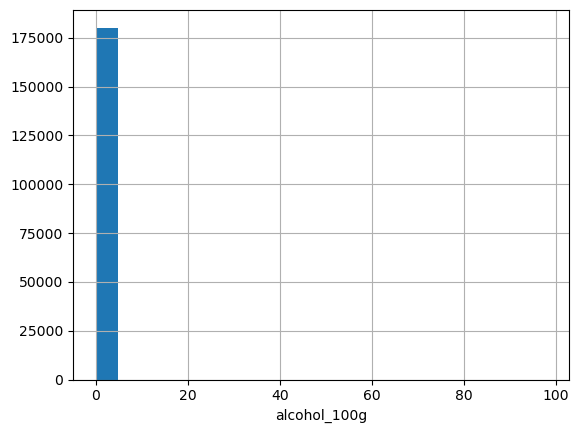

moyenne :  0.0006765653288305287
médiane :  0.0
mode :  0    0.0
Name: pantothenic-acid_100g, dtype: float64
min :  0.0
max :  60.0
quartiles :  [0.0, 0.0]
variance :  0.027676146123578504
écart-type :  0.16636149230990477
coefficient de variation :  245.89124689180795
skewness :  310.0990768427725
kurtosis :  103330.58842914595


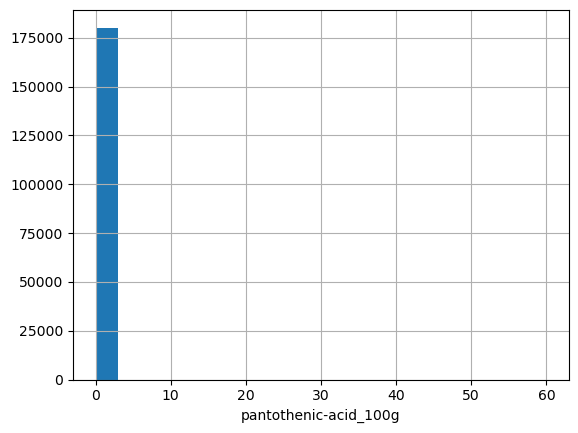

moyenne :  9.946463859166187e-05
médiane :  0.0
mode :  0    0.0
Name: copper_100g, dtype: float64
min :  0.0
max :  16.483516
quartiles :  [0.0, 0.0]
variance :  0.0015086435818662534
écart-type :  0.03884126133207125
coefficient de variation :  390.5032168420035
skewness :  424.18303127237857
kurtosis :  180013.18358361963


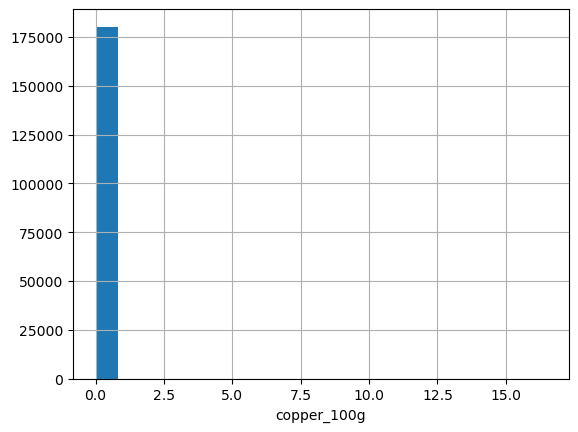

moyenne :  0.0024485611208542378
médiane :  0.0
mode :  0    0.0
Name: folates_100g, dtype: float64
min :  0.0
max :  166.666667
quartiles :  [0.0, 0.0]
variance :  0.26806448618350914
écart-type :  0.5177494434410423
coefficient de variation :  211.4504878115574
skewness :  264.3621541226561
kurtosis :  76226.14518184219


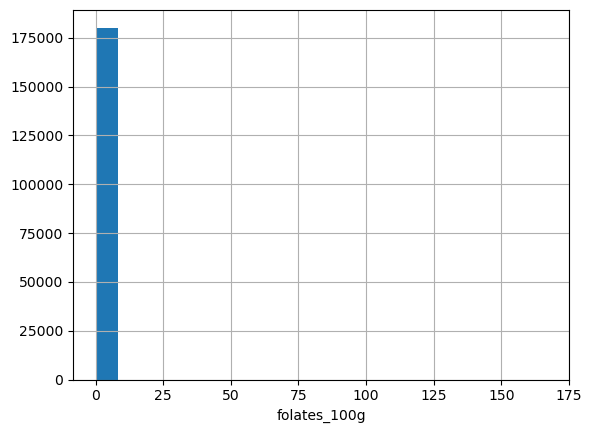

moyenne :  0.45395356968432266
médiane :  0.0
mode :  0    0.0
Name: fruits-vegetables-nuts_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.0, 0.0]
variance :  29.06325055781478
écart-type :  5.39103427533296
coefficient de variation :  11.875739360485396
skewness :  13.869329644178048
kurtosis :  209.4028252796281


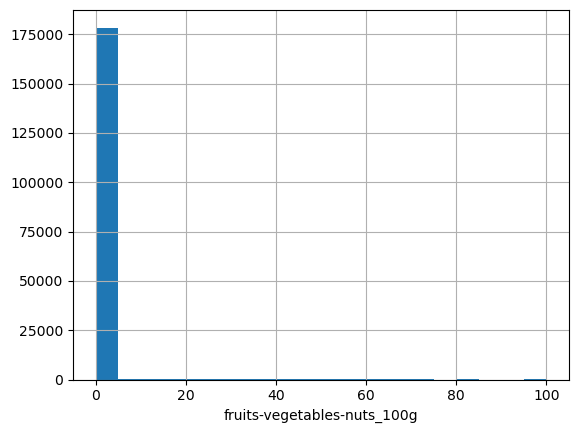

moyenne :  2.655628191182347e-07
médiane :  0.0
mode :  0    0.0
Name: vitamin-b12_100g, dtype: float64
min :  0.0
max :  0.0339
quartiles :  [0.0, 0.0]
variance :  6.436715335549232e-09
écart-type :  8.022914268237715e-05
coefficient de variation :  302.10984711175735
skewness :  418.9338388998821
kurtosis :  176914.44487678664


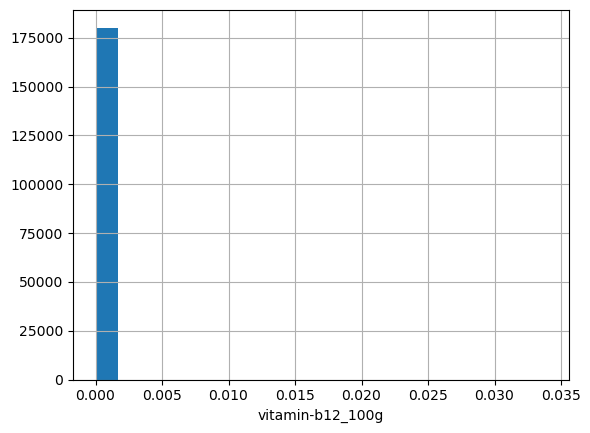

moyenne :  0.00019885481885184036
médiane :  0.0
mode :  0    0.0
Name: vitamin-b9_100g, dtype: float64
min :  0.0
max :  23.076923
quartiles :  [0.0, 0.0]
variance :  0.003267402960849378
écart-type :  0.05716120153433951
coefficient de variation :  287.45193032977636
skewness :  374.35500387082266
kurtosis :  148353.84065028402


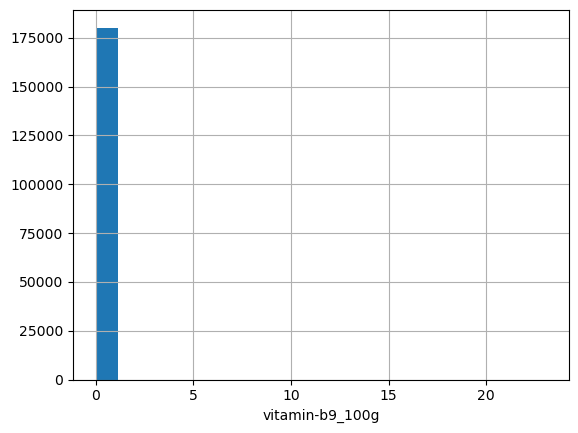

moyenne :  0.012863796877081207
médiane :  0.0
mode :  0    0.0
Name: magnesium_100g, dtype: float64
min :  0.0
max :  657.143
quartiles :  [0.0, 0.0]
variance :  4.960086466995247
écart-type :  2.227125157460902
coefficient de variation :  173.13124412193272
skewness :  254.69989960583933
kurtosis :  68599.43561412406


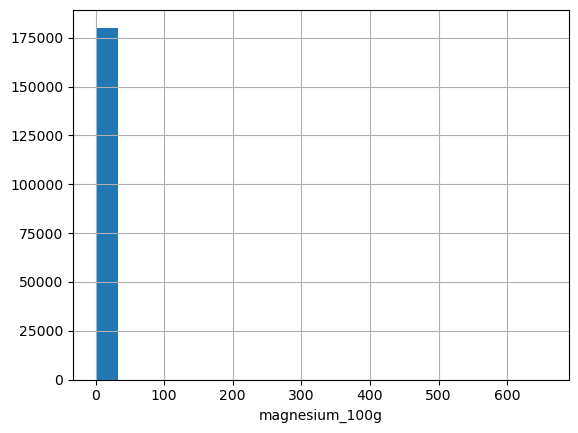

moyenne :  0.01706376975758114
médiane :  0.0
mode :  0    0.0
Name: phosphorus_100g, dtype: float64
min :  0.0
max :  559.459
quartiles :  [0.0, 0.0]
variance :  4.685736131794676
écart-type :  2.164656123220193
coefficient de variation :  126.8568524993414
skewness :  203.8833358474261
kurtosis :  43585.957898332716


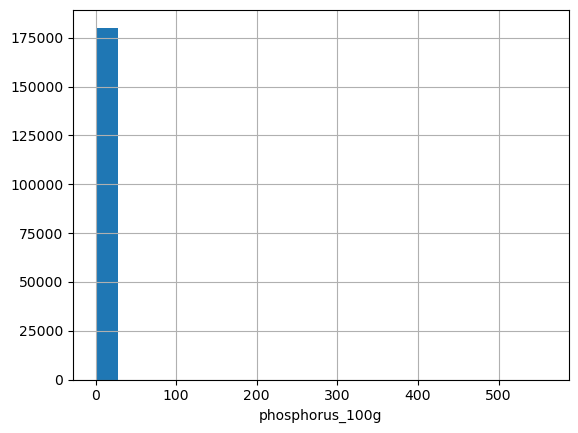

moyenne :  0.0008457465601829239
médiane :  0.0
mode :  0    0.0
Name: vitamin-b6_100g, dtype: float64
min :  0.0
max :  92.6
quartiles :  [0.0, 0.0]
variance :  0.054842805044714095
écart-type :  0.23418540741197794
coefficient de variation :  276.89785384563277
skewness :  362.80290812213445
kurtosis :  138664.77065197364


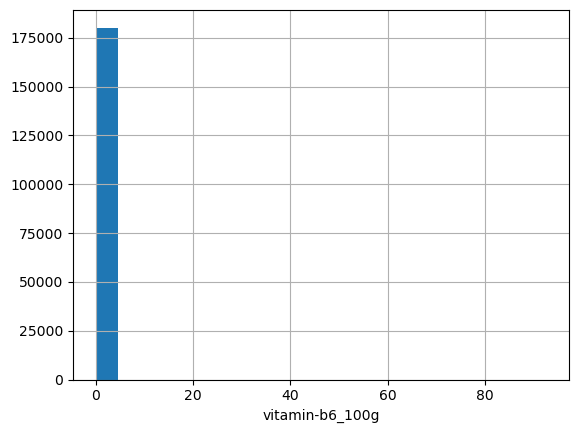

moyenne :  7.398330040403144e-08
médiane :  0.0
mode :  0    0.0
Name: vitamin-d_100g, dtype: float64
min :  0.0
max :  0.000125
quartiles :  [0.0, 0.0]
variance :  9.993379203506594e-13
écart-type :  9.996689053635005e-07
coefficient de variation :  13.512088537604997
skewness :  51.22430643589408
kurtosis :  4203.763107930777


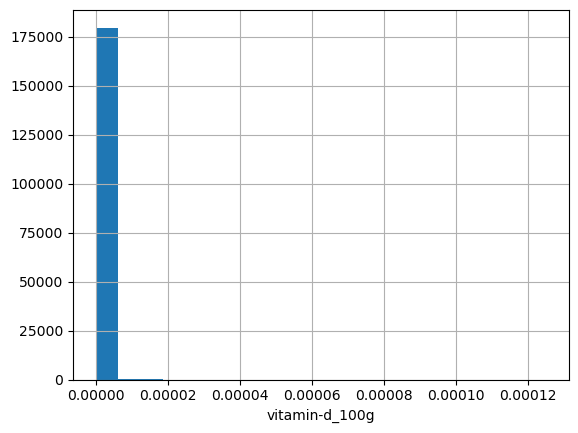

moyenne :  0.008990181509956487
médiane :  0.0
mode :  0    0.0
Name: vitamin-b2_100g, dtype: float64
min :  0.0
max :  35.416667
quartiles :  [0.0, 0.0]
variance :  0.02421319997043855
écart-type :  0.15560591238908164
coefficient de variation :  17.308428335595952
skewness :  116.43928964354393
kurtosis :  21721.571337012156


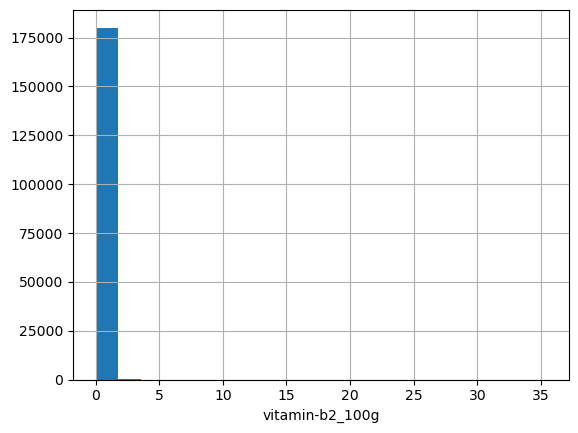

moyenne :  0.0006023347433734404
médiane :  0.0
mode :  0    0.0
Name: vitamin-pp_100g, dtype: float64
min :  0.0
max :  21.428571
quartiles :  [0.0, 0.0]
variance :  0.004474565346051179
écart-type :  0.06689219196626149
coefficient de variation :  111.05484566874655
skewness :  267.3092858508478
kurtosis :  77180.01810098163


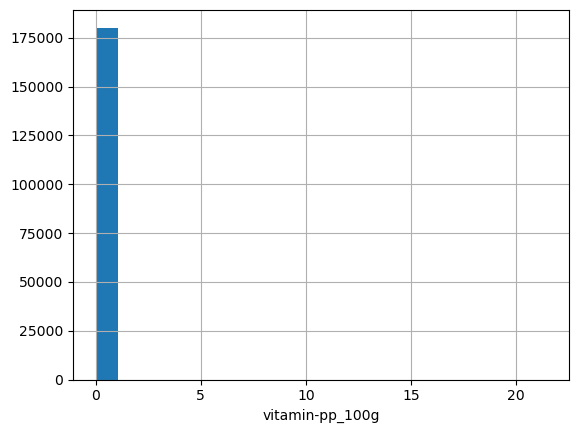

moyenne :  0.012141030765772763
médiane :  0.0
mode :  0    0.0
Name: vitamin-b1_100g, dtype: float64
min :  0.0
max :  161.0
quartiles :  [0.0, 0.0]
variance :  0.2692595686149849
écart-type :  0.5189022727016956
coefficient de variation :  42.739556691063875
skewness :  231.7286453182612
kurtosis :  62015.41294911343


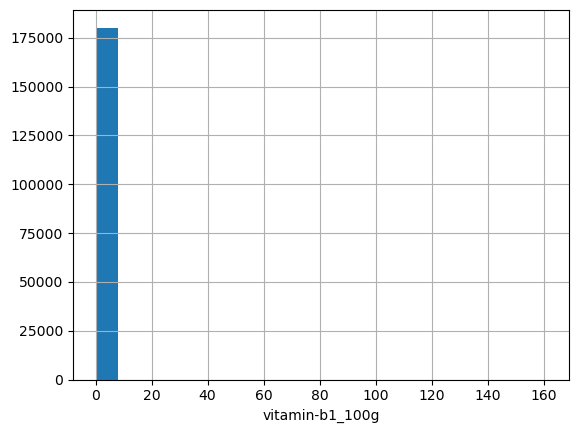

moyenne :  0.6000645479065845
médiane :  0.0
mode :  0    0.0
Name: monounsaturated-fat_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.0, 0.0]
variance :  13.633910676348886
écart-type :  3.6924125820862552
coefficient de variation :  6.153358992741351
skewness :  10.600419037200822
kurtosis :  151.35465431814862


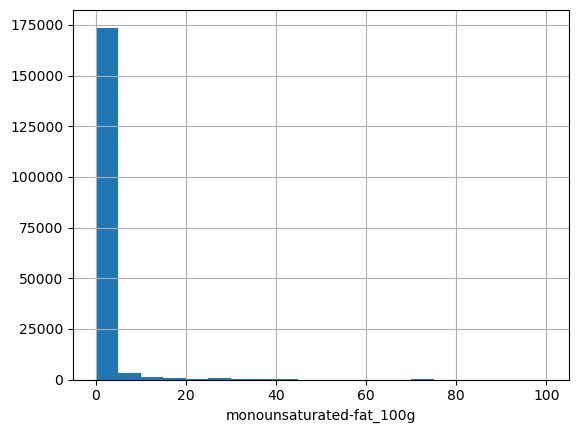

moyenne :  0.40524525152066776
médiane :  0.0
mode :  0    0.0
Name: polyunsaturated-fat_100g, dtype: float64
min :  0.0
max :  75.0
quartiles :  [0.0, 0.0]
variance :  6.838974504354799
écart-type :  2.6151433047454207
coefficient de variation :  6.4532361451051985
skewness :  11.733098133910463
kurtosis :  193.5909163688957


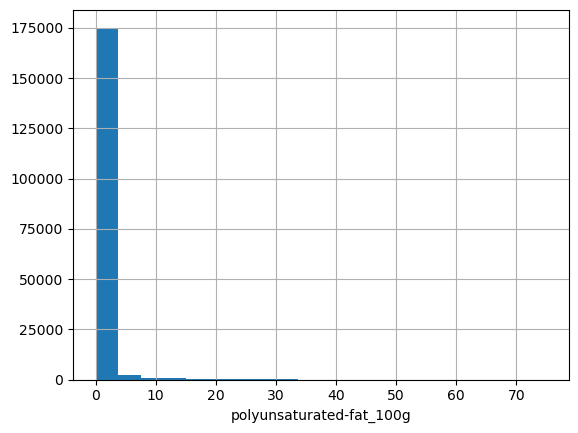

moyenne :  0.03128124931403455
médiane :  0.0
mode :  0    0.0
Name: potassium_100g, dtype: float64
min :  0.0
max :  600.0
quartiles :  [0.0, 0.0]
variance :  2.081751088995368
écart-type :  1.442827463349436
coefficient de variation :  46.12435548416864
skewness :  400.0453346729995
kurtosis :  165972.84955150035


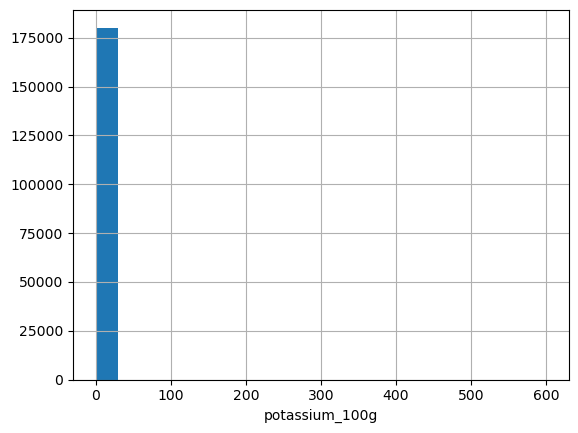

moyenne :  8.086810178484216e-05
médiane :  0.0
mode :  0    0.0
Name: vitamin-a_100g, dtype: float64
min :  0.0
max :  0.8
quartiles :  [0.0, 0.0]
variance :  3.915856282647803e-06
écart-type :  0.0019788522639772287
coefficient de variation :  24.470121349480504
skewness :  369.054128696915
kurtosis :  148302.86617090588


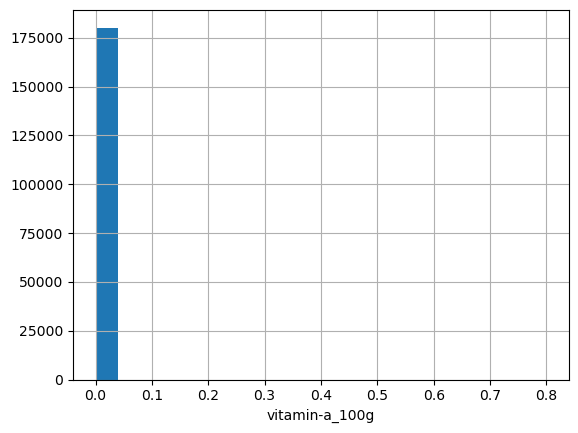

moyenne :  0.005086621072903253
médiane :  0.0
mode :  0    0.0
Name: vitamin-c_100g, dtype: float64
min :  0.0
max :  152.9412
quartiles :  [0.0, 0.0]
variance :  0.1409230438268171
écart-type :  0.37539718143163664
coefficient de variation :  73.80089376647314
skewness :  380.9291890220794
kurtosis :  153375.32404831675


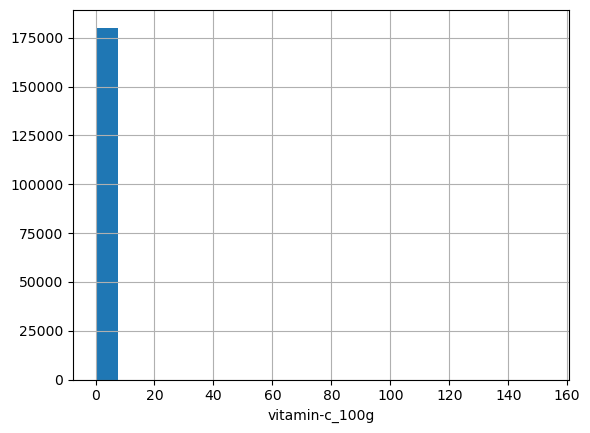

moyenne :  0.0019981744251209867
médiane :  0.0
mode :  0    0.0
Name: iron_100g, dtype: float64
min :  0.0
max :  50.0
quartiles :  [0.0, 0.00129]
variance :  0.022163962661219498
écart-type :  0.14887566174905653
coefficient de variation :  74.50583886841726
skewness :  255.77314457022766
kurtosis :  77055.71087774498


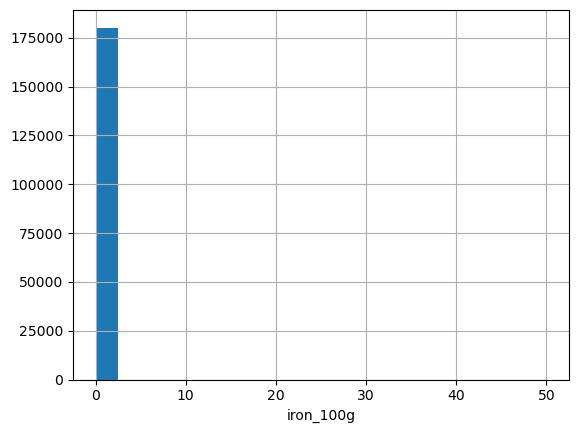

moyenne :  0.06327965308795455
médiane :  0.0
mode :  0    0.0
Name: calcium_100g, dtype: float64
min :  0.0
max :  694.737
quartiles :  [0.0, 0.054]
variance :  5.683949557337153
écart-type :  2.3841035122949576
coefficient de variation :  37.675672920981576
skewness :  245.9570993850823
kurtosis :  65785.47634454338


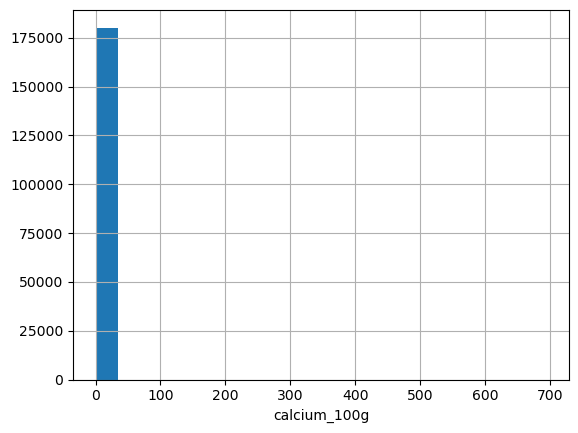

moyenne :  0.04504762254140211
médiane :  0.0
mode :  0    0.0
Name: trans-fat_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.0, 0.0]
variance :  0.8865584139829383
écart-type :  0.9415723094818254
coefficient de variation :  20.901709265931856
skewness :  62.35193408430981
kurtosis :  5495.908947993549


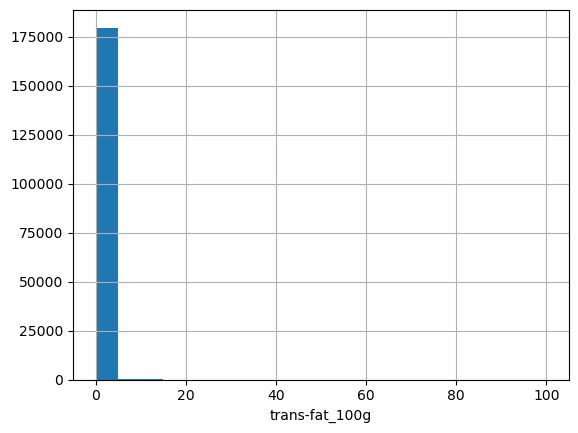

moyenne :  0.011153311159703416
médiane :  0.0
mode :  0    0.0
Name: cholesterol_100g, dtype: float64
min :  0.0
max :  95.238
quartiles :  [0.0, 0.0]
variance :  0.10212447985089448
écart-type :  0.319569209797963
coefficient de variation :  28.652406915047536
skewness :  248.8026810577803
kurtosis :  65101.21454366544


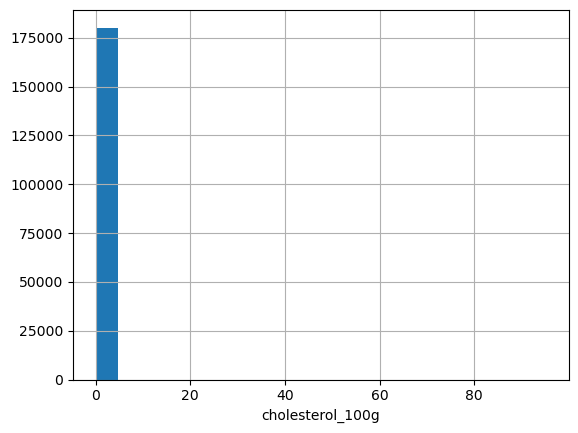

moyenne :  2.464386679505395
médiane :  1.0
mode :  0    0.0
Name: fiber_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.0, 3.3]
variance :  18.42451442082745
écart-type :  4.292378643692498
coefficient de variation :  1.7417634494575271
skewness :  5.338023177521574
kurtosis :  58.56005503238876


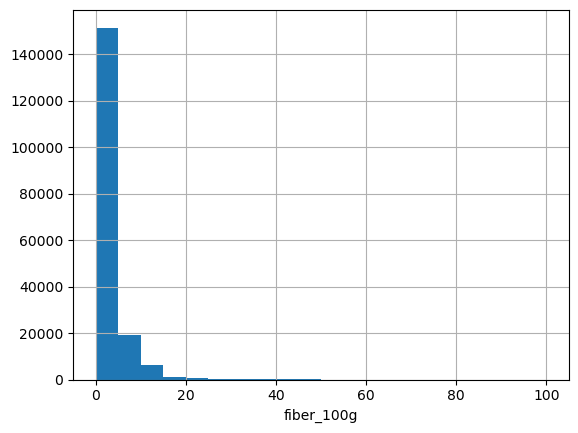

moyenne :  1.8197398215157838
médiane :  1.0
mode :  0    0.0
Name: additives_n, dtype: float64
min :  0.0
max :  31.0
quartiles :  [0.0, 3.0]
variance :  6.440411742458895
écart-type :  2.537796631422403
coefficient de variation :  1.3945931178823692
skewness :  2.4046246717944495
kurtosis :  8.850541414296627


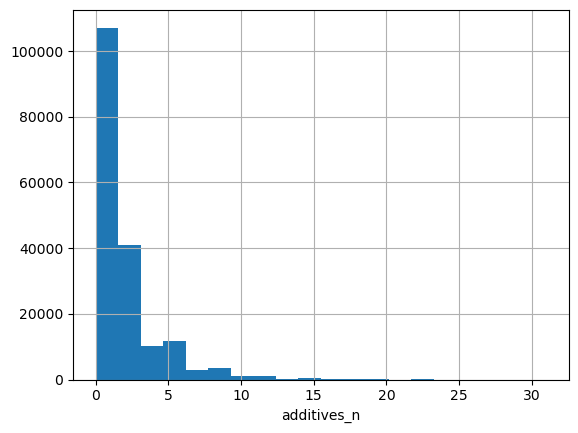

moyenne :  0.022454823957732097
médiane :  0.0
mode :  0    0.0
Name: ingredients_from_palm_oil_n, dtype: float64
min :  0.0
max :  2.0
quartiles :  [0.0, 0.0]
variance :  0.022483393543671137
écart-type :  0.1499446349279331
coefficient de variation :  6.677613470058008
skewness :  6.682203453629947
kurtosis :  44.66209176636062


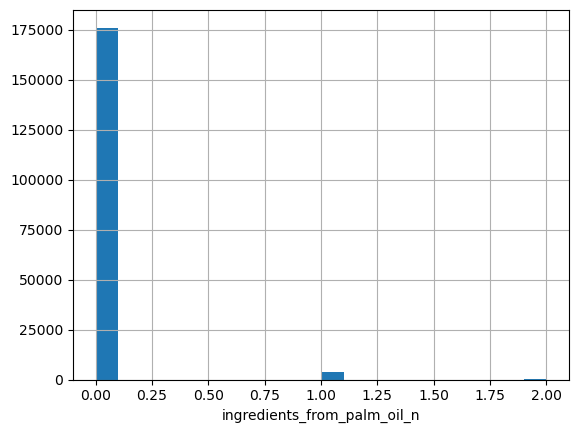

moyenne :  0.05761332859743373
médiane :  0.0
mode :  0    0.0
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64
min :  0.0
max :  6.0
quartiles :  [0.0, 0.0]
variance :  0.07699305174620422
écart-type :  0.2774762183434901
coefficient de variation :  4.816180996628786
skewness :  5.911807536942771
kurtosis :  44.09376001269559


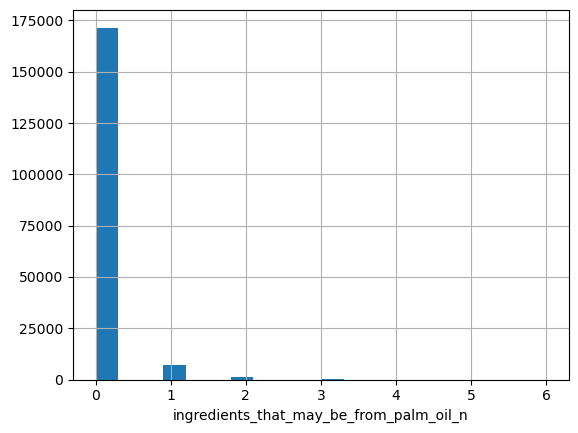

moyenne :  1.2809034613128452
médiane :  0.68072
mode :  0    0.0
Name: salt_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.11684, 1.36144]
variance :  16.972431859798043
écart-type :  4.119761141109766
coefficient de variation :  3.2162932379675757
skewness :  15.070152558917611
kurtosis :  288.7916817507484


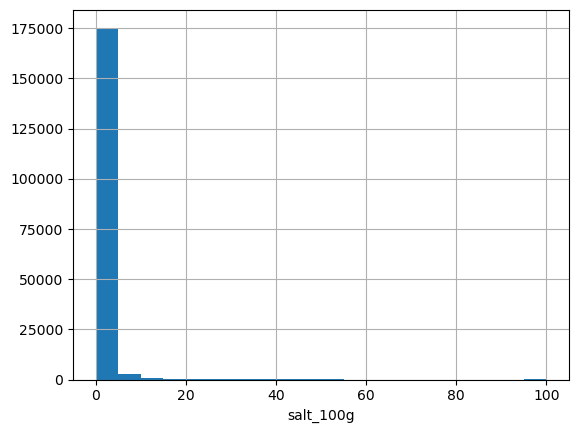

moyenne :  4.941751185066377
médiane :  1.9
mode :  0    0.0
Name: saturated-fat_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [0.0, 7.14]
variance :  54.20445912458982
écart-type :  7.362367766187031
coefficient de variation :  1.48982971632315
skewness :  3.2280304021325112
kurtosis :  19.85639450631318


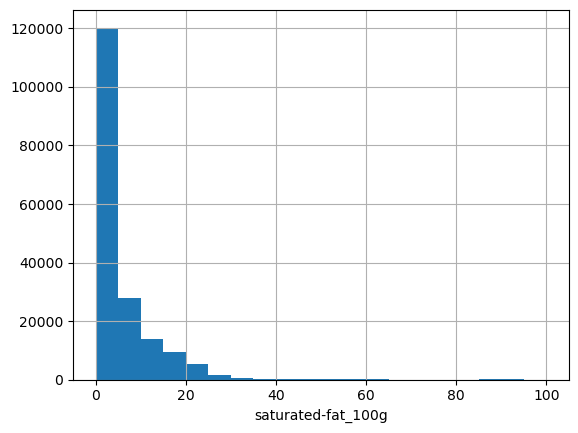

In [53]:
for col in [x for x in data_num.columns if x not in ["energy_100g", "nutrition-score-fr_100g", "carbohydrates_100g", "fat_100g", "sugars_100g", "proteins_100g"]] :
    print("moyenne : ", data[col].mean())
    print("médiane : ", data[col].median())
    print("mode : ", data[col].mode())
    print("min : ", data[col].min())
    print("max : ", data[col].max())
    quartiles = [np.nanpercentile(data[col], p) for p in [25, 75]]
    print("quartiles : ", quartiles)
    # mesures de dispersion
    print("variance : ", data[col].var(ddof=0))
    print("écart-type : ", data[col].std(ddof=0))
    print("coefficient de variation : ", data[col].std(ddof=0)/data[col].mean())
    # mesures de forme
    print("skewness : ", data[col].skew())
    print("kurtosis : ", data[col].kurtosis())
    data[col].hist(bins=20)
    # plt.ylim((0, 25000))
    plt.xlabel(col)
    plt.show()

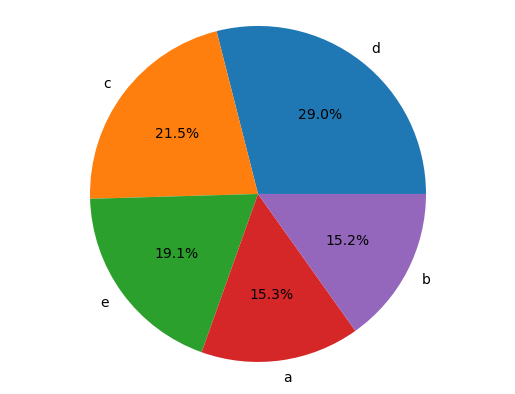

In [54]:
# répartition des Nutri-Grade dans le dataset
temp_val_count = data["nutrition_grade_fr"].value_counts(normalize=True)
temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.axis('equal')
plt.show()

In [55]:
# majorité des produits
maj_produits = data.loc[(data["nutrition_grade_fr"]=="d") | (data["nutrition_grade_fr"]=="c") | (data["nutrition_grade_fr"]=="e"),:]
print("Les principales notes de produits représentent ", round(len(maj_produits)/len(data)*100, 1), " % du total.")

Les principales notes de produits représentent  69.6  % du total.


***
# IV) Analyse de la problématique

A ce stade là, nous avons une meilleure compréhension du dataset avec toutes les colonnes restantes pour notre application. Pour mener à bien notre objectif, nous devons encore répondre à quelques questions :  
1) Quelle est la corrélation entre les variables restantes ?
2) Quelle est la corrélation entre le Nutri-Score et le Nutri-Grade ?
3) Quelles sont les corrélations fortes entre le Nutri-Score et les autres variables ?
4) Quelles sont les colonnes que nous devons prendre en compte pour notre application ? Utilisation du PCA.

Selon les lois européennes, voici la liste des variables étant obligatoirement sur une étiquette de produit : 
- `energy_100g` : valeur énergétique du produit en kJ pour 100g
- `fat_100g` : teneur en matière grasse pour 100g
- `saturated-fat_100g` : teneur en matière grasse saturée pour 100g
- `carbohydrates_100g` : teneur en glucide pour 100g
- `sugars_100g` : teneur en sucre pour 100g
- `proteins_100g` : teneur en protéine pour 100g
- `salt_100g` : teneur en sel pour 100g  

In [56]:
# colonnes de type numérique ne contenant pas la target Nutri-Score
col_num_wo_nutriscore = [x for x in data_num.columns if x != "nutrition-score-fr_100g"]
# colonnes contenant les teneurs en vitamine pour 100g
col_vitamins = ['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
                'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'biotin_100g',
                 'pantothenic-acid_100g']
col_real_vitamins = [x for x in col_vitamins if x in data.columns]
col_num_wo_vitamins = [x for x in col_num_wo_nutriscore if x not in col_real_vitamins]

['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'pantothenic-acid_100g']


## 1) Quelle est la corrélation entre les variables restantes ?

Faisons une analyse à l'aide d'une heatmap maintenant que nous avons beaucoup moins de variables à étudier. C'est plus lisible et cela nous permet donc de distinguer les plus fortes corrélations.

<AxesSubplot: >

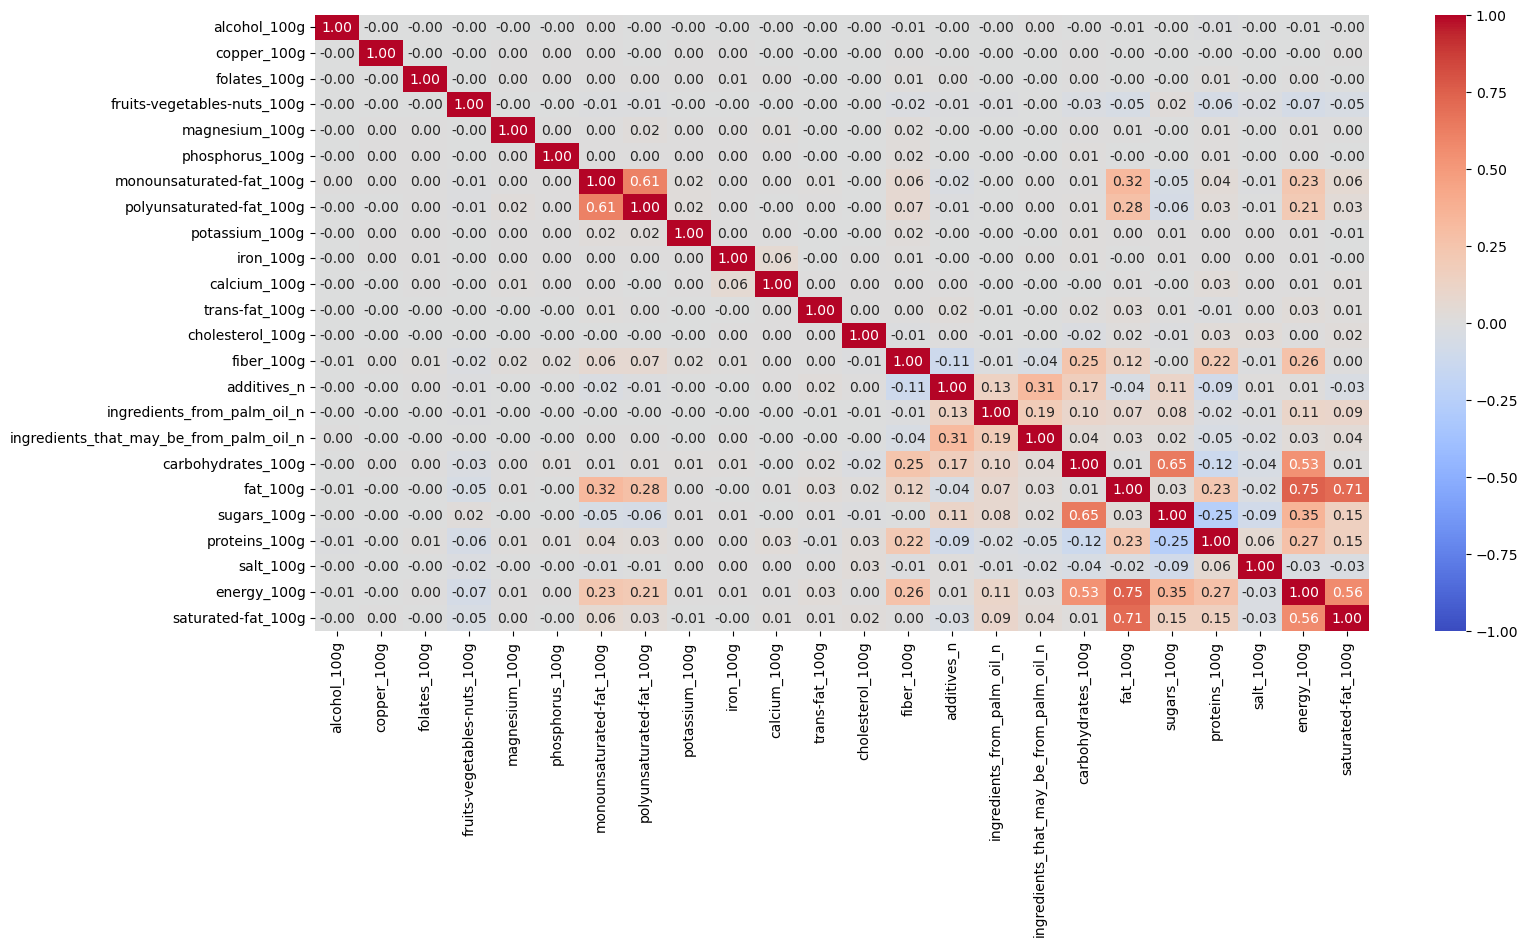

In [57]:
# On prend toutes les variables numériques, exceptée le Nutri-Score
corr = data[col_num_wo_vitamins].corr()
fig, ax = pyplot.subplots(figsize=(17, 8))
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

On peut distinguer plusieurs corrélations : 
 - `fat_100g` et `saturated-fat_100g` (puisque l'un est un des composant de l'autre)
 - `carbohydrates_100g` et `sugars_100g` (puisque l'un est un des composant de l'autre)
 - `energy_100g` avec dans l'ordre d'importance `fat_100g`, `saturated-fat_100g`, `carbohydrates_100g`, `sugars_100g` et `proteins_100g` (puisque que la valeur énergétique est calculée à partir des teneur en protéines, glucides et matières grasses)

Corrélation de Pearson : 0.706
Covariance : 78.7


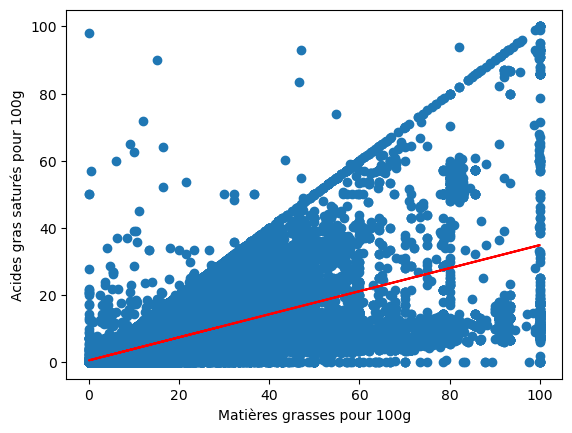

In [58]:
# corrélation entre les matières grasses et les acides gras saturés
print("Corrélation de Pearson :", round(st.pearsonr(data["fat_100g"],data["saturated-fat_100g"])[0], 3))
print("Covariance :", round(np.cov(data["fat_100g"],data["saturated-fat_100g"],ddof=0)[1,0], 1))

plt.plot(data["fat_100g"],data["saturated-fat_100g"],'o')
m, b = np.polyfit(data["fat_100g"], data["saturated-fat_100g"], 1)
plt.plot(data["fat_100g"], m*data["fat_100g"]+b, color='red')
plt.xlabel("Matières grasses pour 100g")
plt.ylabel("Acides gras saturés pour 100g")
plt.show()

Corrélation de Pearson : 0.648
Covariance : 339.1


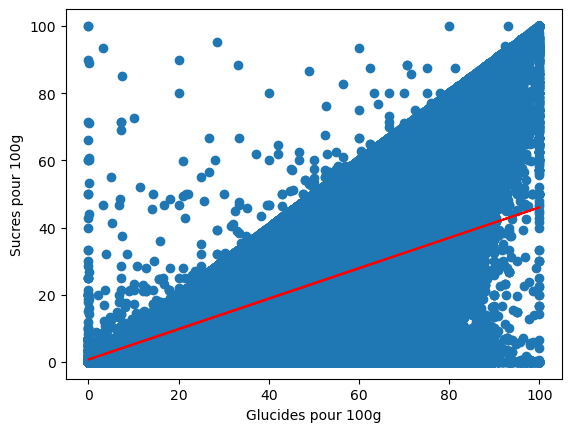

In [59]:
# corrélation entre les glucides et les sucres
print("Corrélation de Pearson :", round(st.pearsonr(data["carbohydrates_100g"],data["sugars_100g"])[0], 3))
print("Covariance :", round(np.cov(data["carbohydrates_100g"],data["sugars_100g"],ddof=0)[1,0], 1))

plt.plot(data["carbohydrates_100g"],data["sugars_100g"],'o')
m, b = np.polyfit(data["carbohydrates_100g"], data["sugars_100g"], 1)
plt.plot(data["carbohydrates_100g"], m*data["carbohydrates_100g"]+b, color='red')
plt.xlabel("Glucides pour 100g")
plt.ylabel("Sucres pour 100g")
plt.show()

Ces corrélations sont trop faibles pour que nous puissions en déduire quoi que ce soit ou faire de nouvelles approximations.

## 2) Quelle est la corrélation entre le Nutri-Score et le Nutri-Grade ?

Comme nous avons vu plus haut, nous avons deux colonnes qui peuvent servir de target pour notre étude : `nutrition-score-fr_100g` et `nutrition_grade_fr`. Vérifions d'abord qu'il sa'git bien de deux variables corrélées par la méthode ANOVA.

Correlation de 0.927 . Les 2 variables sont hautement corrélées.


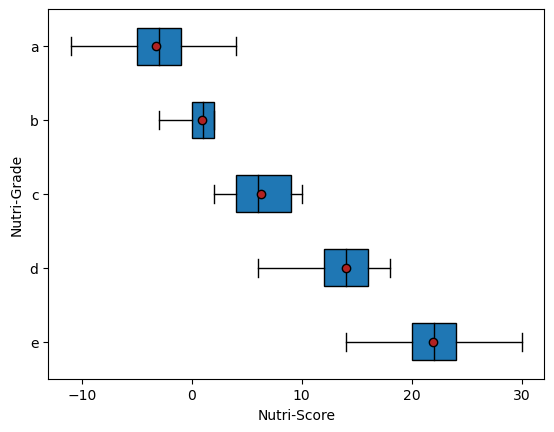

In [60]:
X = "nutrition_grade_fr" # qualitative
Y = "nutrition-score-fr_100g" # quantitative
print("Correlation de", round(eta_squared(data[X],data[Y]), 3), ". Les 2 variables sont hautement corrélées.")
modalites = sorted(data[X].unique(), reverse=True)
groupes = []
for m in modalites:
    groupes.append(data[data[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Nutri-Score")
plt.ylabel("Nutri-Grade")
plt.show()

Nous confirmons qu'il y a bien une corrélation forte entre le Nutri-Score et le Nutri-Grade.

## 3) Quelles sont les corrélations fortes entre le Nutri-Score et les autres variables ?

In [61]:
# on fait la transcription pour le Nutri-Grade pour passer de lettres à chiffres pour une meilleure exploitation
code = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].replace(code).astype(np.float64)
col_ns = "nutrition-score-fr_100g"

Corrélation de Pearson : 0.648
Covariance : 4334.8


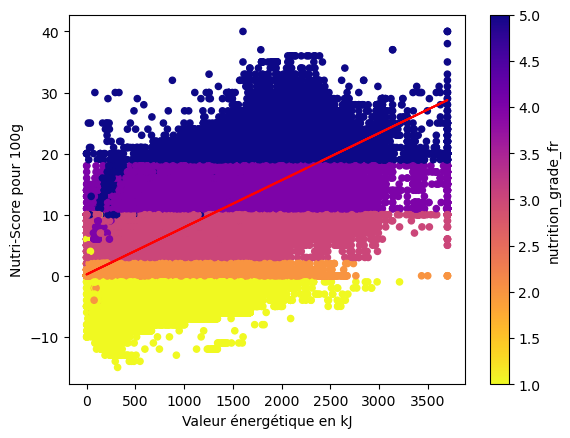

In [62]:
# corrélation entre le Nutri-Score et la valeur énergétique
corr_pears = st.pearsonr(data["energy_100g"],data[col_ns])[0]
print("Corrélation de Pearson :", round(corr_pears, 3))
print("Covariance :", round(np.cov(data["energy_100g"],data[col_ns],ddof=0)[1,0], 1))
# plt.plot(data[col],data[nutri_score],'o')
data.plot.scatter("energy_100g", col_ns, c="nutrition_grade_fr", colormap='plasma_r')
m, b = np.polyfit(data["energy_100g"],data[col_ns], 1)
plt.plot(data["energy_100g"], m*data["energy_100g"]+b, color='red')
plt.xlabel("Valeur énergétique en kJ")
plt.ylabel("Nutri-Score pour 100g")
plt.show()

Corrélation de Pearson : 0.63
Covariance : 41.4


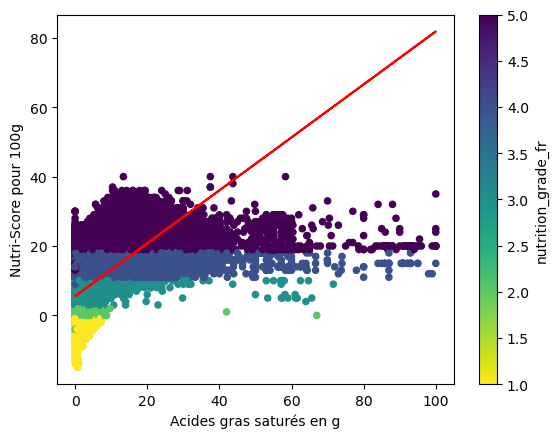

In [63]:
# corrélation entre le Nutri-Score et les acides gras saturés
corr_pears = st.pearsonr(data["saturated-fat_100g"],data[col_ns])[0]
print("Corrélation de Pearson :", round(corr_pears, 3))
print("Covariance :", round(np.cov(data["saturated-fat_100g"],data[col_ns],ddof=0)[1,0], 1))
# plt.plot(data[col],data[nutri_score],'o')
data.plot.scatter("saturated-fat_100g", col_ns, c="nutrition_grade_fr", colormap='viridis_r')
m, b = np.polyfit(data["saturated-fat_100g"],data[col_ns], 1)
plt.plot(data["saturated-fat_100g"], m*data["saturated-fat_100g"]+b, color='red')
plt.xlabel("Acides gras saturés en g")
plt.ylabel("Nutri-Score pour 100g")
plt.show()

Il n'y a que 2 variables ayant un coefficient de Pearson supérieur à 0.6 montrant un tant soit peu de corrélation.

## 4) Quelles sont les colonnes que nous devons prendre en compte pour notre application ? Utilisation du PCA.

Il reste encore beaucoup de colonnes numériques. Nous pouvons encore en réduire le nombre en passant par la méthode du PCA.  
C'est possible de l'utiliser car nous avons au préalable traité les valeurs manquantes et les outliers. En effet, la méthode du PCA n'accepte pas les premiers et n'est pas robuste aux seconds.

L'échantillon présente 221042 lignes et 34 colonnes
Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.
Ici, la méthode des valeurs propres nous demande de garder 24 composantes.
La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.
Ici, la méthode des 95% d'inertie nous demande de garder 28 composantes.


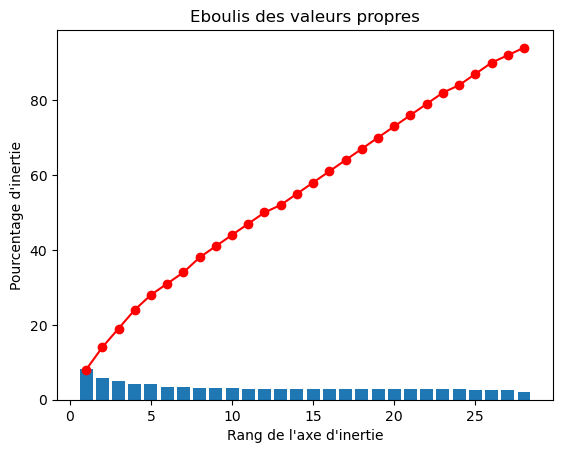

In [64]:
# tracé de l'éboulis des valeurs propres
pca = compute_pca(data_drop_nrj[col_num_wo_nutriscore], 28)

On voit sur la représentation d'éboulis des valeurs propres que 28 variables sont nécessaires pour regrouper 95% des variables. Nous devons effectuer une autre approche en regardans directement les coefficients de corrélation entre les composantes et les variables.

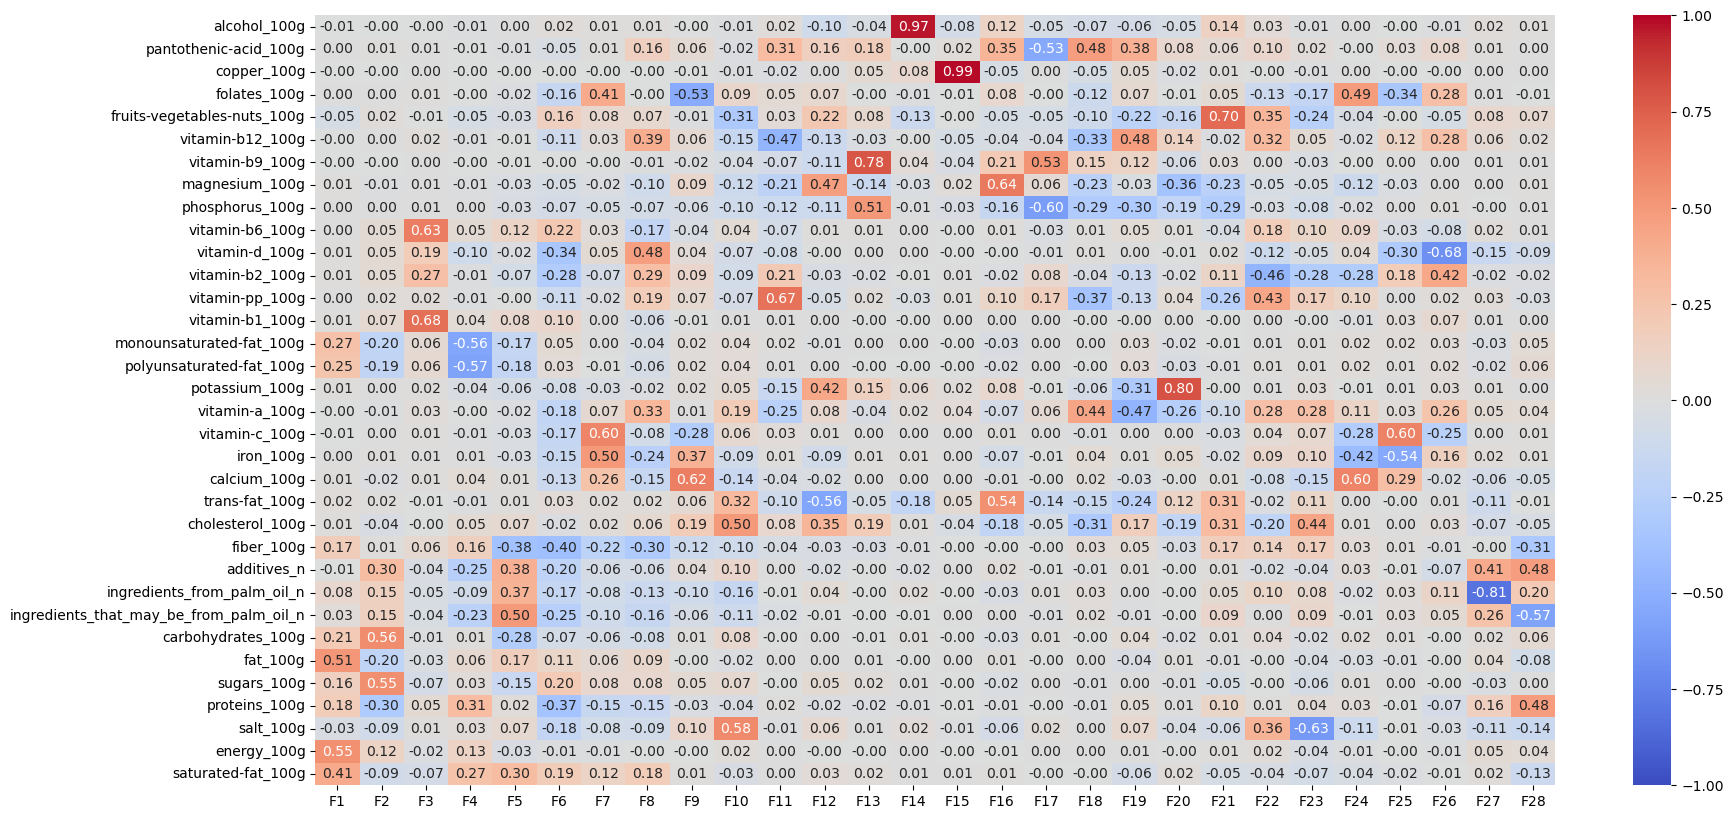

In [65]:
# heatmap de corrlation entre les variables et les composantes
pcs = show_components_heatmap(data_drop_nrj[col_num_wo_nutriscore], pca)

Malheureusement, on ne peut utiliser ces données telles quelles pour remplacer des variables par leur composantes. Nous allons donc devoir effectuer une autre approche pour parvenir à nos fins. Utilisons la méthode des coefficients.

In [66]:
# on parcourt toutes les lignes et on relève toutes les variables ayant une "importance" (> 0.65) dans une composante
reduc_var = compute_components(pcs, threshold=0.65)

vitamin-b1_100g : 0.6833020418459078
vitamin-pp_100g : 0.6723674581231648
vitamin-b9_100g : 0.7842260848632479
alcohol_100g : 0.9657056667581239
copper_100g : 0.9908811892153275
potassium_100g : 0.8046054693823121
fruits-vegetables-nuts_100g : 0.7041102520112469
vitamin-d_100g : -0.6774868282442605
ingredients_from_palm_oil_n : -0.8125675569486072
Il y a 9 variables ayant un impact conséquent sur les composantes.
Voici la liste : ['vitamin-pp_100g', 'vitamin-d_100g', 'vitamin-b1_100g', 'alcohol_100g', 'fruits-vegetables-nuts_100g', 'ingredients_from_palm_oil_n', 'copper_100g', 'potassium_100g', 'vitamin-b9_100g']


Cette approche technique nous renvoie une liste de variables pertinentes dans le dataset. Cependant, notre approche métier nous dicte d'y ajouter les variables étant obligatoire sur l'étiquette d'un produit. Pour une meilleure performance des modèles, nous ajoutons également la variable `fiber_100g`.

In [67]:
col_num_to_keep = ["nutrition-score-fr_100g"] + reduc_var + col_mandatory + ["fiber_100g"]
col_num_to_keep = list(set(col_num_to_keep))
col_to_keep = col_num_to_keep + data_categ.columns.values.tolist()
# data_col_keep = data_drop_nrj[col_num_to_keep + data_categ.columns.values.tolist()]
print("Après traitement pas la méthode du PCA, nous avons sélectionné", len(col_num_to_keep), "colonnes de type numérique pour notre étude.")

Après traitement pas la méthode du PCA, nous avons sélectionné 18 colonnes de type numérique pour notre étude.


# V) Etudes de modèles pour quantifier la qualité des produits

5) Quantifions on qualifier nos produits à l'aide d'une Régression Linéaire ?
6) Peut on qualifier nos produits à l'aide d'un KNN ?

## 5) Modèles de Machine Learning

Nous allons maintenant utiliser deux modèles de machine Learning pour qualifier la qualité de nos produits.

In [68]:
# prenons un échantillon de 20% de notre dataset
neo_data = data.sample(n=int(data.shape[0]*0.2), random_state=101)

In [69]:
# on définit les valeurs et les targets pour chaque modèle
X = neo_data[data_num.columns]
y_reg_lin = neo_data["nutrition-score-fr_100g"]
y_knn = neo_data["nutrition_grade_fr"]

In [70]:
# on définit les variables qui seront utiliser pour les modèles

# variables issues de la méthode du PCA et de la réflexion métier
col_num_wo_nutriscore = [x for x in col_num_to_keep if x != "nutrition-score-fr_100g"]
# mêmes données mais sans les vitamines
col_wo_vitamins = [x for x in col_num_wo_nutriscore if x not in col_real_vitamins]
# mêmes données mais avec toutes les vitamines
col_w_vitamins = col_num_wo_nutriscore + col_real_vitamins
col_w_vitamins = list(set(col_w_vitamins))

### 5a) Peut on qualifier nos produits à l'aide d'une Régression Linéaire ?

In [77]:
# on sépare l'échantillon en données d'entraînement et données de test à hauteur de 80/20%
X_train, X_test, y_train, y_test = train_test_split(X, y_reg_lin, test_size=0.2, random_state=101)
for inputSet in [col_num_wo_nutriscore, col_wo_vitamins, col_w_vitamins]:
    model = LinearRegression()
    model.fit(X_train[inputSet],y_train)
    predictions = model.predict(X_test[inputSet])
    print("Performance de prédiction de la Régression Linéaire :", round(r2_score(y_test, predictions)*100, 3), "%")

Performance de prédiction de la Régression Linéaire : 69.747 %
Performance de prédiction de la Régression Linéaire : 70.104 %
Performance de prédiction de la Régression Linéaire : 69.848 %


### 5b) Peut on qualifier nos produits à l'aide d'un KNN ?

In [72]:
# on sépare l'échantillon en données d'entraînement et données de test à hauteur de 80/20%
X_train, X_test, y_train, y_test = train_test_split(X, y_knn, test_size=0.2, random_state=101)
for inputSet in [col_num_wo_nutriscore, col_wo_vitamins, col_w_vitamins]:
    model = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance', p=1, leaf_size=20, metric='minkowski')
    model.fit(X_train[inputSet], y_train)
    print("Performance de prédiction du KNN :", round(model.score(X_test[inputSet], y_test)*100, 3), "%")

Performance de prédiction du KNN : 68.049 %
Performance de prédiction du KNN : 67.966 %
Performance de prédiction du KNN : 68.105 %


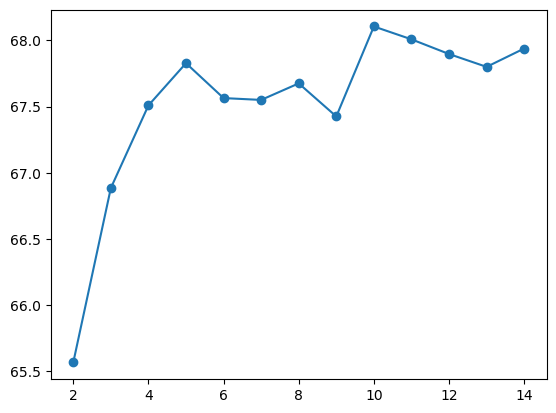

In [73]:
# tracé des performances du KNN en fonction du nombre de plus proches voisins
performances = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k, weights='distance', p=1, leaf_size=20, metric='minkowski')
    performances.append(100*knn.fit(X_train[col_w_vitamins], y_train).score(X_test[col_w_vitamins], y_test))
plt.plot(range(2,15), performances, 'o-')
plt.show()

***
# VI) Présentation du prototype

***
# VII) Synthèse de l'analyse de données